# **02. 가격 결정 구조 분석(다이아몬드 가격)_데이터분석 캡스톤**
-------------



In [4]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson,t, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [5]:
my_dpi = 200
fpath = "../글꼴/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(fpath)
fprop = fm.FontProperties(fname=fpath)
fname = fprop.get_name()
plt.rcParams['font.family'] = fname
plt.rcParams['font.size'] = 6
plt.rcParams['axes.unicode_minus'] = False

In [6]:
origin = load_data('diamonds')

def check_data(origin):
    # 0. 데이터 타입 확인
    print("\n===== 타입확인 =====")
    print(origin.info())
    
    # 1. 데이터 크기
    print(f"\n[1] 데이터 규모: {origin.shape[0]}행, {origin.shape[1]}열")
    
    # 2. 중복 데이터 확인
    dup_count = origin.duplicated().sum()
    print(f"[2] 전체 중복 행 수: {dup_count}건")
    
    # 3. 결측치 확인(비율 포함)
    miss_info = origin.isnull().sum()
    miss_cols = miss_info[miss_info > 0]
    print(f"[3] 결측치 존재 컬럼: {len(miss_cols)}개")
    if not miss_cols.empty:
        for col, count in miss_cols.items():
            print(f"    - {col}: {count}개 ({(count/len(origin))*100:.2f}%)")

    # # 4. 데이터 이상치 요약(수치형)
    # print("\n[4] 기술통계량")
    # display(origin.describe().T)      # min,max 확인 필요
    
    # # 5. 범주형 데이터 고유값 확인(일관성 확인)
    # print("\n[5] 범주형 데이터 고유값 개수")
    # cat_cols = origin.select_dtypes(include=['object']).columns         # 카테고리가 많거나 하나뿐인 컬럼 확인
    # for col in cat_cols:
    #     print(f"    - {col}: {origin[col].nunique()}개의 고유값")

check_data(origin)

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   colo

## **미션1. " 이 데이터는 얼마나 믿을 수 있을까?"**
------
1. 데이터 안에 비어 있는 값, 유난히 튀는 값, 현실적으로 말이 되지 않는 값들을 확인
2. 품질 변수들이 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려있는지 확인

-------------
🧠 어떻게 미션을 풀어나갈 것 인가?

1. 비어 있는 값(null), 유난히 튀는 값(이상치), 현실적으로 말이 되지 않는 값
2. 품질변수(object)가 몇 개의 범주로 구성되어 있는지, 특정 범주 확인 -> barplot
---------------

### **[1] 연속형 데이터 확인**
#### 1. 결측치 확인

In [7]:
# 결측치 확인
origin.isnull().sum()


price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

#### 2. 이상치 확인_기술통계량 확인

In [8]:
# 기술통계량 확인
origin.describe().T

count         mean          std    min     25%      50%      75%  \
price  53940.0  3932.799722  3989.439738  326.0  950.00  2401.00  5324.25   
carat  53940.0     0.797940     0.474011    0.2    0.40     0.70     1.04   
x      53940.0     5.731157     1.121761    0.0    4.71     5.70     6.54   
y      53940.0     5.734526     1.142135    0.0    4.72     5.71     6.54   
z      53940.0     3.538734     0.705699    0.0    2.91     3.53     4.04   
depth  53940.0    61.749405     1.432621   43.0   61.00    61.80    62.50   
table  53940.0    57.457184     2.234491   43.0   56.00    57.00    59.00   

            max  
price  18823.00  
carat      5.01  
x         10.74  
y         58.90  
z         31.80  
depth     79.00  
table     95.00

> x,y,z는 다이아몬드의 크기를 나타내는데 어떻게 min값이 나올 수 있을까?

#### 3. 변수들에 대한 필터링

In [9]:
# 연속형 변수 필터링하는 것을 권장
drop_df = origin.copy()

drop_df = origin.drop(columns=['cut','color','clarity'])
#drop_df = origin.filter(['price', 'carat','x','y','z','depth','table'])
drop_df.head()

price  carat     x     y     z  depth  table
0    326   0.23  3.95  3.98  2.43   61.5   55.0
1    326   0.21  3.89  3.84  2.31   59.8   61.0
2    327   0.23  4.05  4.07  2.31   56.9   65.0
3    334   0.29  4.20  4.23  2.63   62.4   58.0
4    335   0.31  4.34  4.35  2.75   63.3   58.0

#### 4. Boxplot 시각화

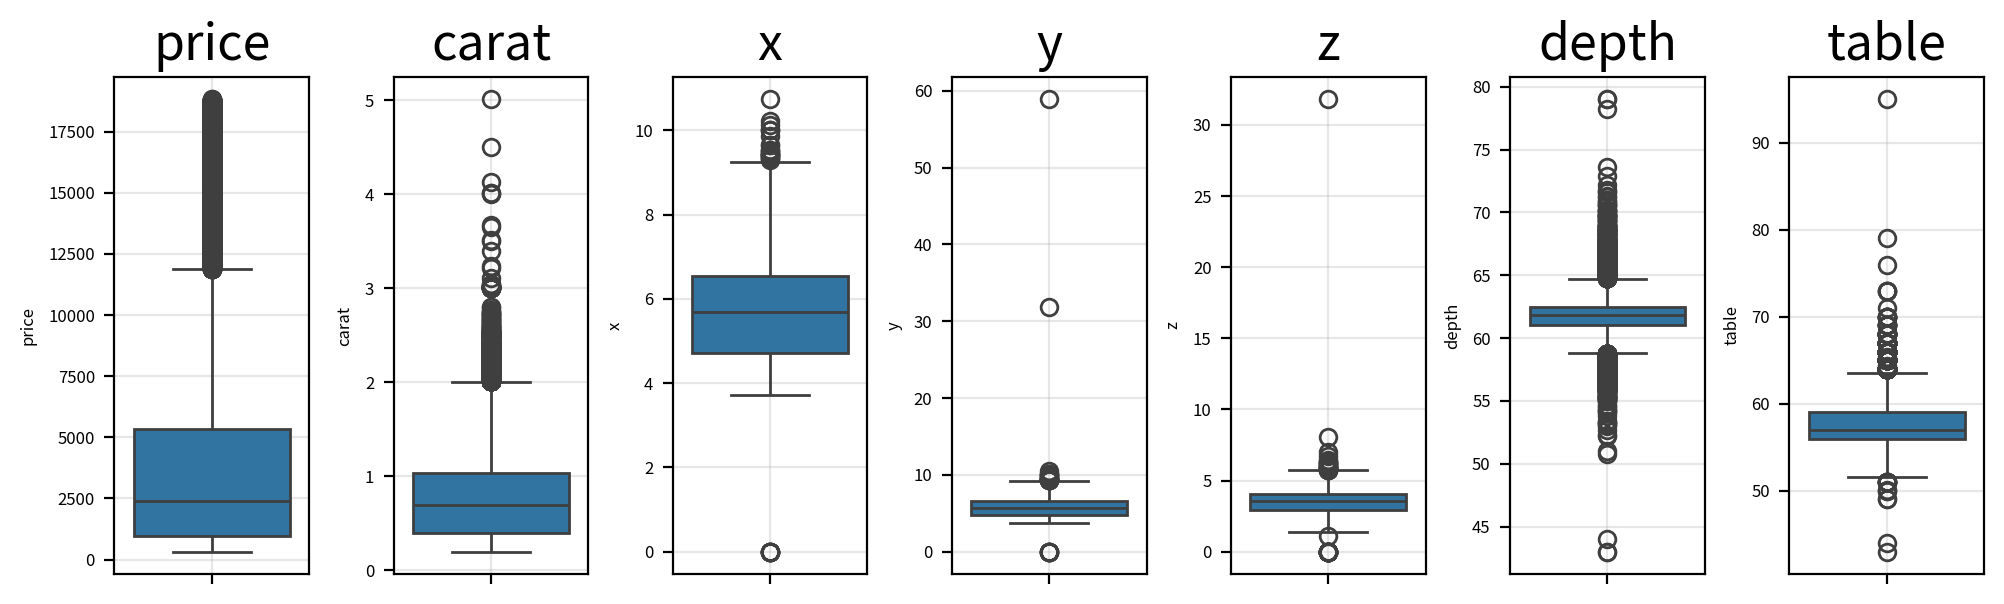

변수명  전체_개수  이상치_개수  이상치_비율(%)
0  price  53940    3540       6.56
1  carat  53940    1889       3.50
2      x  53940      32       0.06
3      y  53940      29       0.05
4      z  53940      49       0.09
5  depth  53940    2545       4.72
6  table  53940     605       1.12

In [10]:
# width_px = 800
# height_px = 800
# cols_count = len(drop_df.columns) 
# rows = cols_count
# cols = 2  
# fig, ax = plt.subplots(rows, cols, figsize=(20, rows * 5))

width_px = 2000
height_px = 600
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1,7, figsize=figsize, dpi=my_dpi)

axes = ax.flatten()     #여러 개의 서브플롯을 반복문으로 일괄 처리하기 위해

outlier_summary = []

for i, v in enumerate(drop_df.columns):
    if i < len(axes):
        sb.boxplot(data=drop_df, y=v, ax=axes[i])
        axes[i].set_title(v, fontsize=18, fontweight='bold')
        axes[i].grid(alpha=0.3)

        Q1 = drop_df[v].quantile(0.25)
        Q3 = drop_df[v].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = drop_df[(drop_df[v] < lower) | (drop_df[v] > upper)][v]

        outlier_summary.append({
            '변수명': v,
            '전체_개수': drop_df[v].count(),
            '이상치_개수': outliers.count(),
            '이상치_비율(%)': round(outliers.count() / drop_df[v].count() * 100, 2)
        })

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)


#### 5.변수들에 대한 데이터 분포

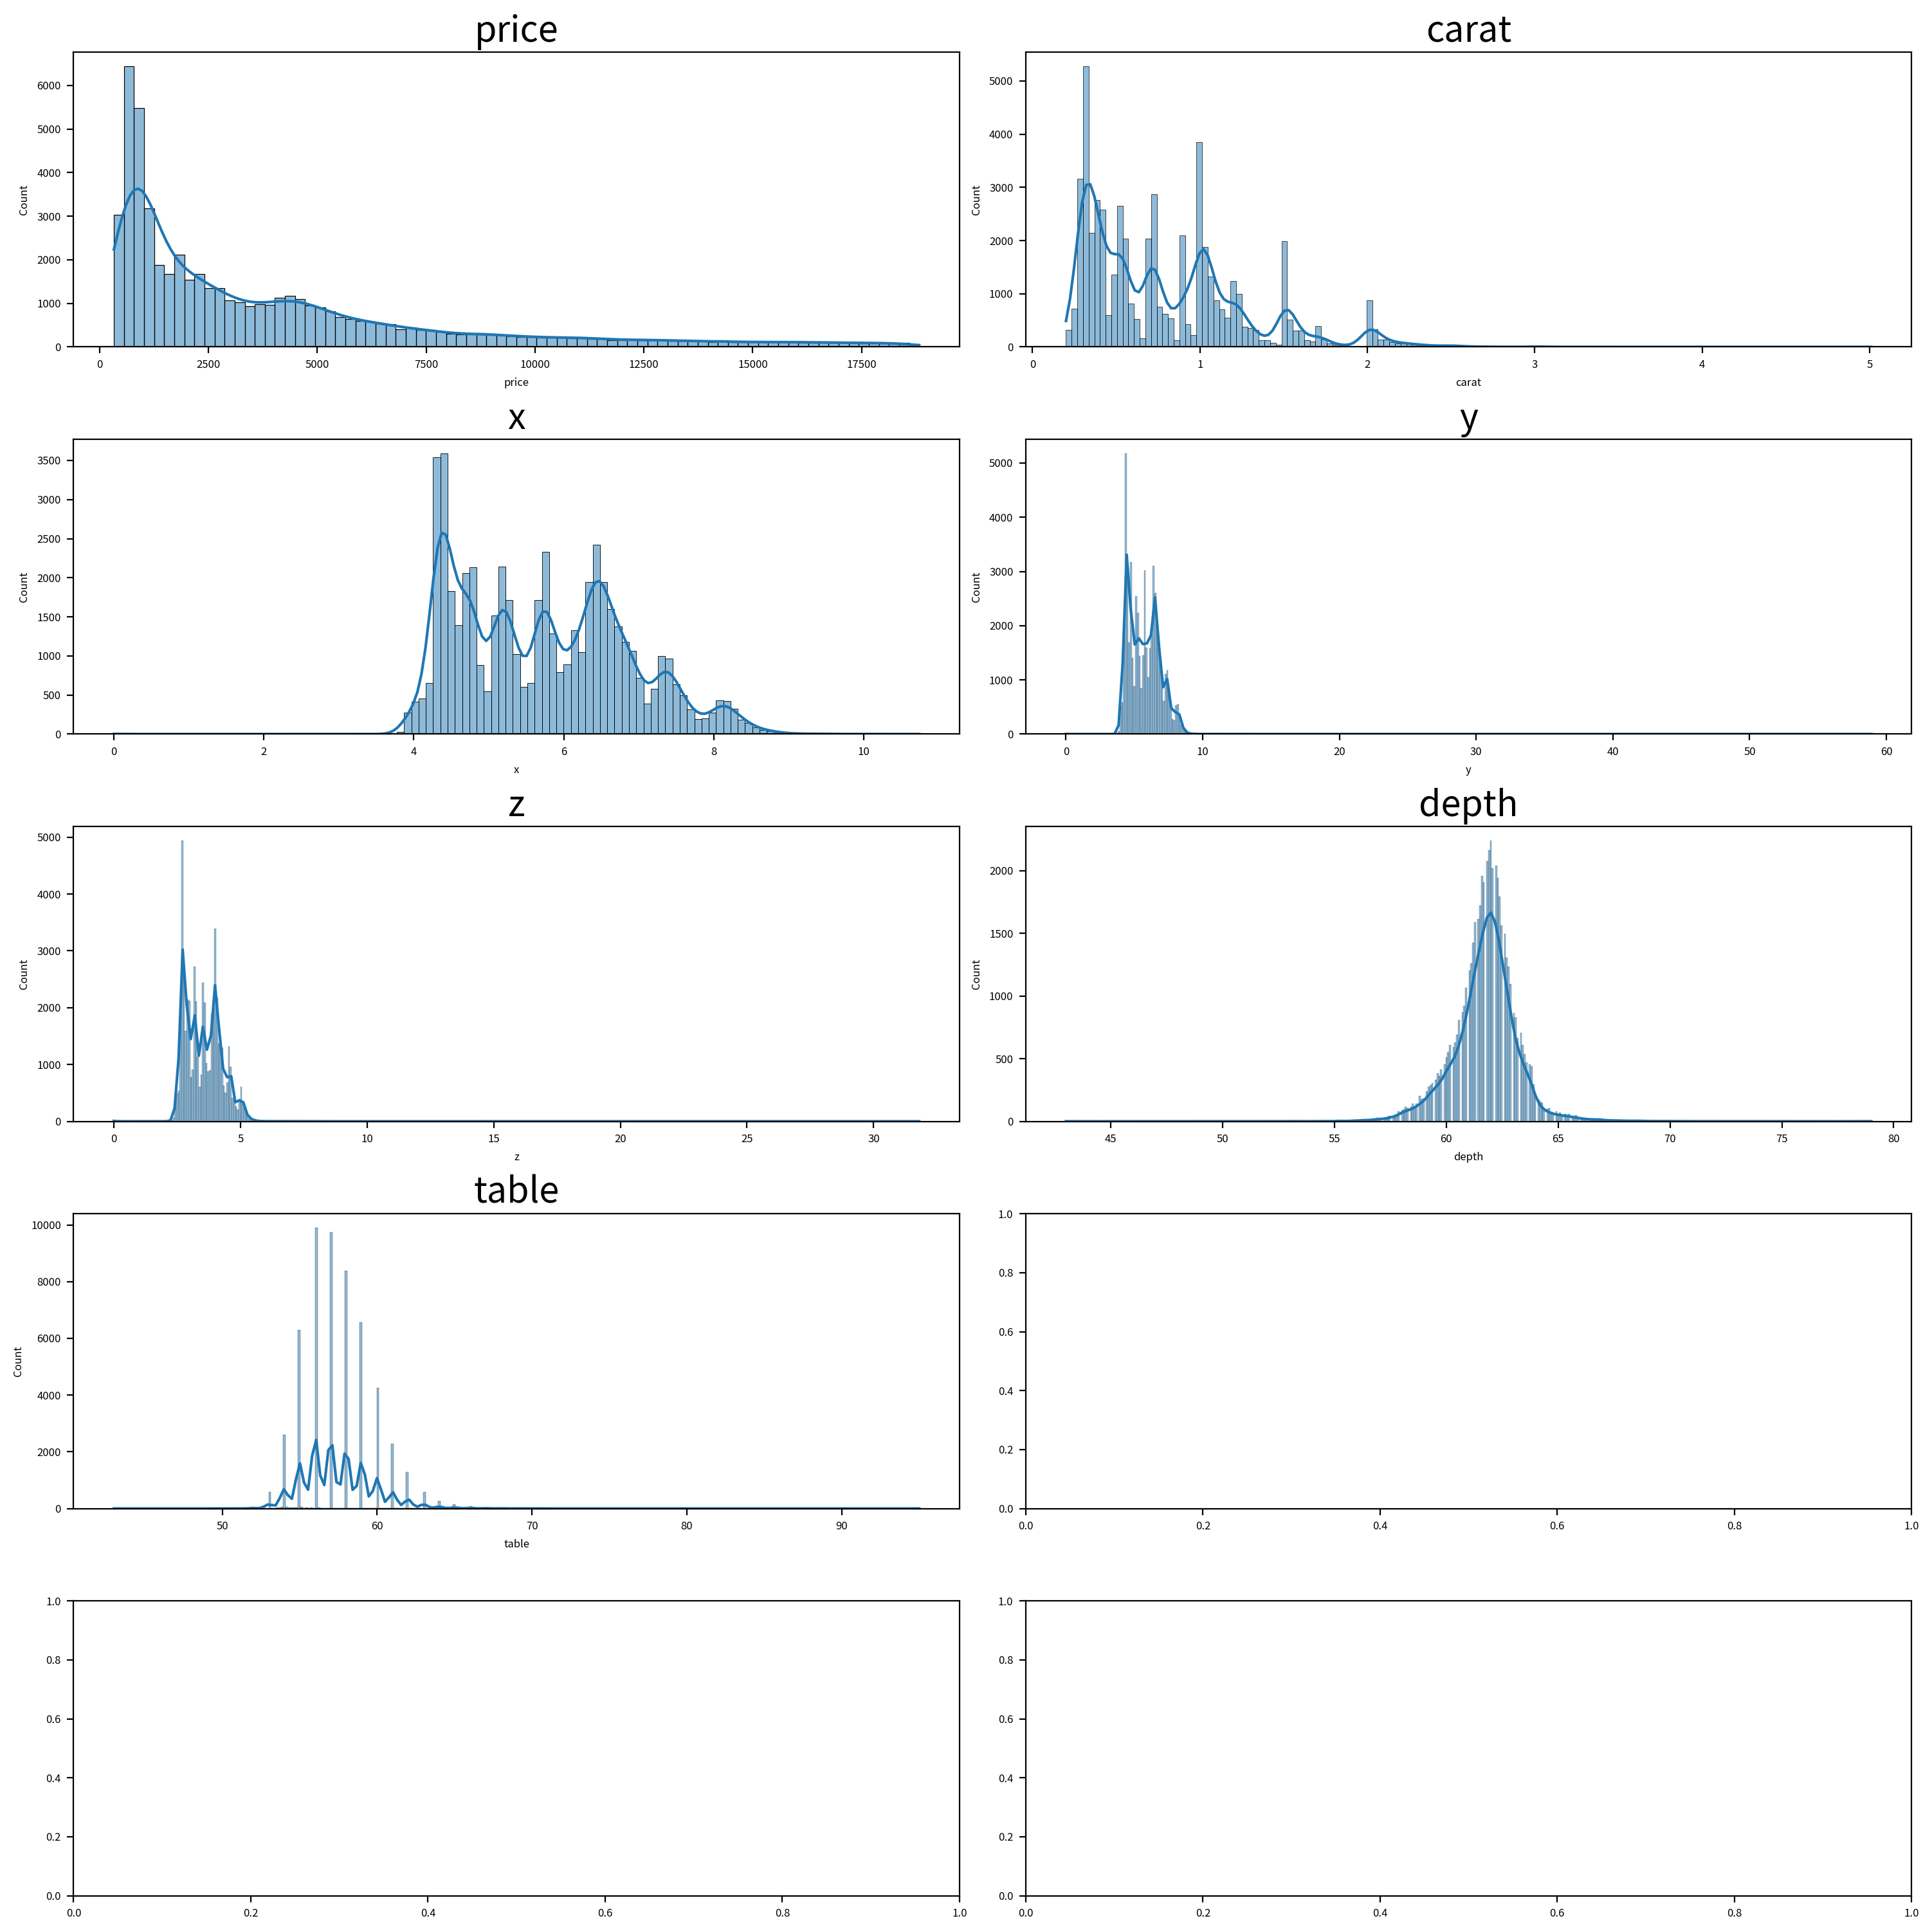

In [11]:
width_px = 3000
height_px = 3000
rows = 5
cols = 2
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

axes_flat = axes.flatten()

for i, v in enumerate(drop_df):
    sb.histplot(drop_df[v], kde=True, ax=axes_flat[i])
    axes_flat[i].set_title(v, fontsize=20)

plt.tight_layout()
plt.show()
plt.close()

#### 6. x,y,z에 대한 전처리

In [12]:
# x,y,z 각각 몇 개의 0이 존재하는지 확인_혹시 모르니 다른 변수들도 함께 확인하고자 함

zero_count={}

for i in drop_df:
    zero_count[i] = (drop_df[i] == 0).sum()

zero_df2 = pd.Series(zero_count)
zero_df2

price     0
carat     0
x         8
y         7
z        20
depth     0
table     0
dtype: int64

In [13]:
# x,y,z에서 하나라도 0이 포함되어 있는 행을 삭제한 데이터 

drop_df.copy()

#zero_df3 = (df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0)
zero_df3= origin.query('x != 0 and y != 0 and z != 0').copy()
zero_df3.head()
zero_df3.shape
zero_df3.describe().T

count         mean          std     min     25%      50%      75%  \
price  53920.0  3930.993231  3987.280446  326.00  949.00  2401.00  5323.25   
carat  53920.0     0.797698     0.473795    0.20    0.40     0.70     1.04   
x      53920.0     5.731627     1.119423    3.73    4.71     5.70     6.54   
y      53920.0     5.734887     1.140126    3.68    4.72     5.71     6.54   
z      53920.0     3.540046     0.702530    1.07    2.91     3.53     4.04   
depth  53920.0    61.749514     1.432331   43.00   61.00    61.80    62.50   
table  53920.0    57.456834     2.234064   43.00   56.00    57.00    59.00   

            max  
price  18823.00  
carat      5.01  
x         10.74  
y         58.90  
z         31.80  
depth     79.00  
table     95.00

### **[2] 범주형 데이터 정보 확인**

#### 1. 품질 변수(범주형)들의 범주 구성 확인

In [14]:
nor_df = ['cut', 'color', 'clarity']

for i in nor_df:
    print(f"{i} ({origin[i].nunique()}개): {origin[i].unique()}")


cut (5개): ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color (7개): ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity (8개): ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


#### 2. 시각화를 통한 분포 확인

C:\Users\itwill\AppData\Local\Temp\ipykernel_14604\494007703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x=col, data=origin,
C:\Users\itwill\AppData\Local\Temp\ipykernel_14604\494007703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x=col, data=origin,
C:\Users\itwill\AppData\Local\Temp\ipykernel_14604\494007703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x=col, data=origin,


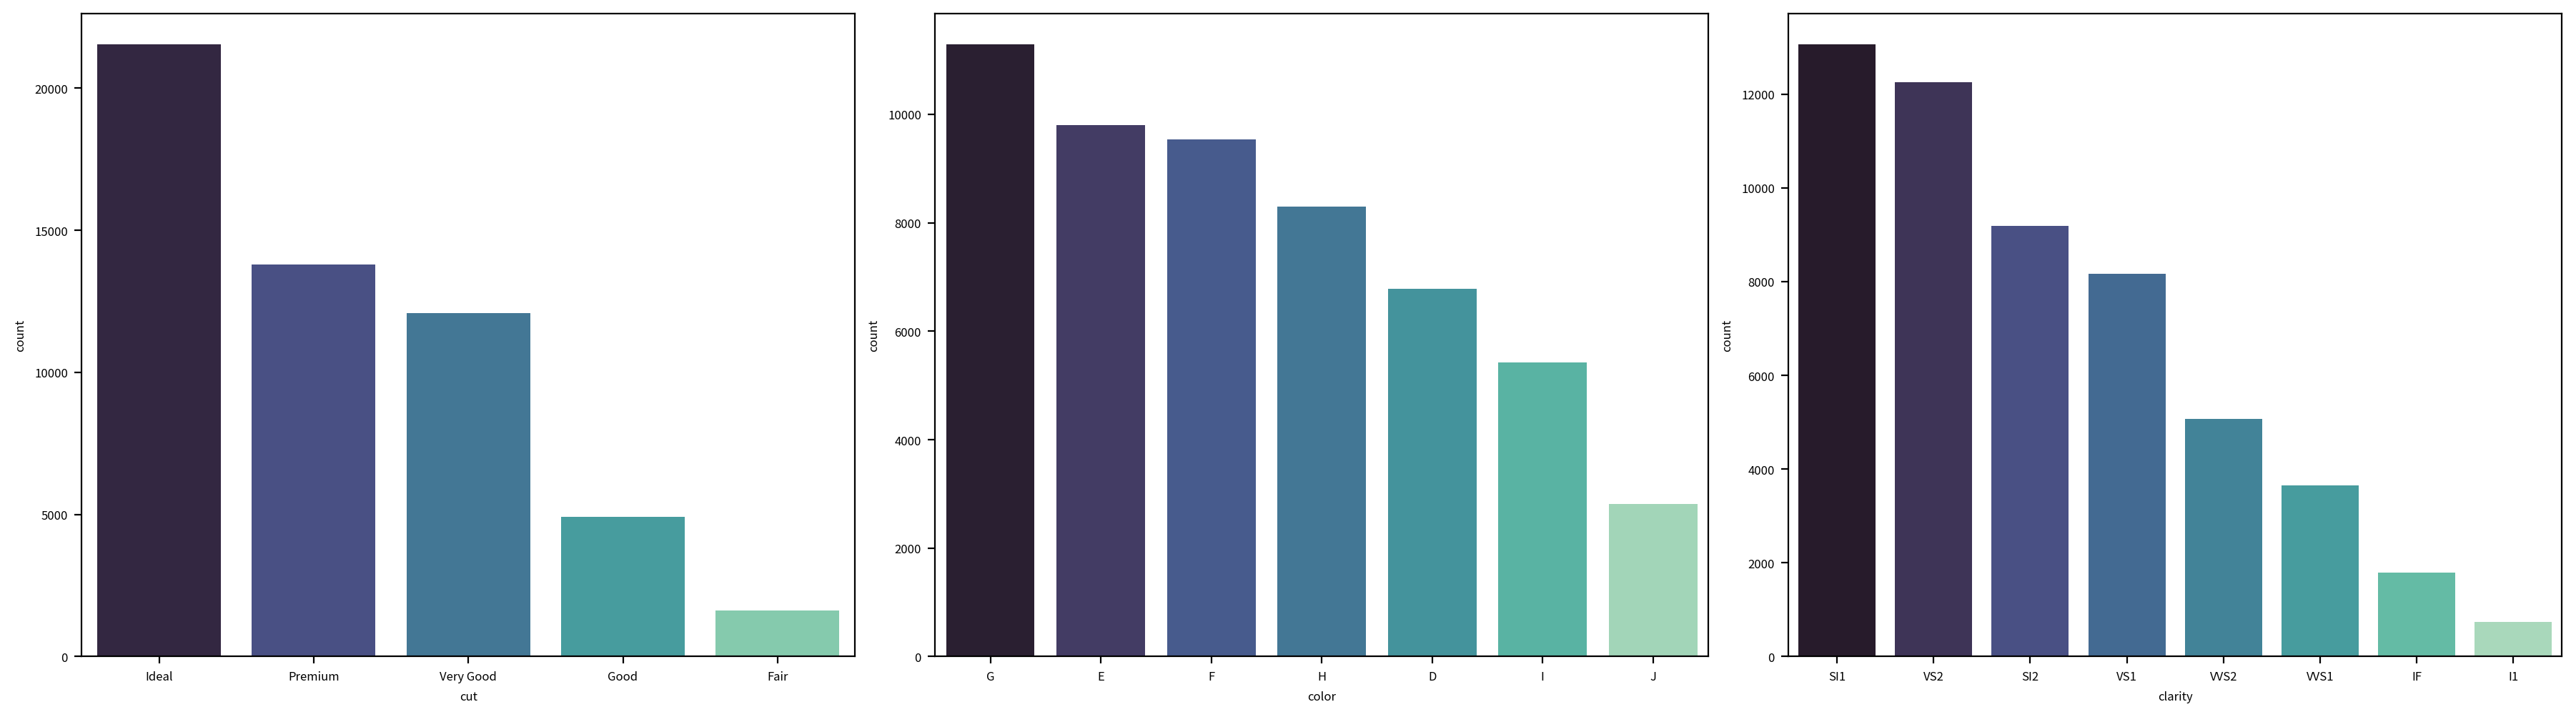


[ cut 등급별 비중 분석 ]
             빈도수  백분율(%)
cut                     
Ideal      21551   39.95
Premium    13791   25.57
Very Good  12082   22.40
Good        4906    9.10
Fair        1610    2.98

[ color 등급별 비중 분석 ]
         빈도수  백분율(%)
color               
G      11292   20.93
E       9797   18.16
F       9542   17.69
H       8304   15.39
D       6775   12.56
I       5422   10.05
J       2808    5.21

[ clarity 등급별 비중 분석 ]
           빈도수  백분율(%)
clarity               
SI1      13065   24.22
VS2      12258   22.73
SI2       9194   17.04
VS1       8171   15.15
VVS2      5066    9.39
VVS1      3655    6.78
IF        1790    3.32
I1         741    1.37


In [15]:
width_px = 1000
height_px = 800
rows = 1
cols = len(nor_df)
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, axes = plt.subplots(rows, cols, figsize=(18, 5), dpi=my_dpi)

for i, col in enumerate(nor_df):
    sb.countplot(x=col, data=origin, 
                 ax=axes[i], palette='mako',
                 order=origin[col].value_counts().index )
    
plt.tight_layout()
plt.show()

# -------------------------
# 범주에 대한 빈도수 확인 
# -------------------------
for col in nor_df:
    print(f"\n[ {col} 등급별 비중 분석 ]")
    counts = origin[col].value_counts()                             #빈도수
    percent = origin[col].value_counts(normalize=True) * 100        #빈도 비율
    summary = pd.DataFrame({'빈도수': counts, '백분율(%)': percent.round(2)})
    print(summary)


### **미션1_인사이트**

> 결측치는 없는 것으로 확인되었으나 이상치는 price, carat등 모든 변수들에서 확인되었다. 
> x,y,z 변수들은 다이아몬드의 물리적 치수를 의미하며 결과에 0이 포함되어 있다면 물리적으로 존재할 수 없기에 이는 분석 결과를 왜곡할 수 있는 이상치라고 판단되었다.
> 
> 이에 x,y,z 각각 0이 몇 개 존재하는지를 확인 후 x,y,z 중 하나라도 0이 존재한다면 해당 행을 삭제하는 것으로 전처리를 시도하였다. 
> 
> 그 결과, 전체 데이터의 크기가 53940에서 53920으로 20개가 줄었으며,  x,y,z의 min값이 5.70, 5.71, 3.53으로 변경되었음을 확인하였다. 
>
> 품질변수들인 cut(컷 품질),color(색상 등급),larity(투명도 등급)의 
> 
> 1. cut(컷 품질)은 Ideal, Premium, Good, Very Good, Fair 로 5개의 범주로 구성되어 있으며,
Ideal 품질이 39.95%로 가장 높은 비중을 차지한다.
>  상위 두 등급(Ideal, Premium)을 합치면 약 65%를 차지하는 반면, 최하위인 Fair등급은 약3%에 불과하다.
이를 통해 시장에 유통되는 다이아몬드 10개 중 6개 이상은 매우 우수한 세공 품질을 갖추고 있음을 확인하였다.
>
> 2. color(색상 등급)는  E, I, J, H, F, G, D로 총 7개의 범주로 구성되어 있고, G(20.93%), E(18.16%), F(17.69%) 등급이 전체의 약 57%를 차지하고 있다. 
> 가장 좋은 색상 등급인 D는 12.56%로 G 등급의 절반정도의 수준임을 알 수 있다. 또한 가장 최하의 등급인 J는 5.21%로 가장 적은 것을 확인할 수 있다.
> 이를 통하여 D등급은 최상급의 희소성을 나타내며 최하위등급인 J는 5.21%로 하급을 기치한다는 것을 알 수 있다.
>
>3. clarity(투명도 등급)은 SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF로 총 8개의 등급으로 구성되어 있으며 SI1은 24.22%로 가장 많이 분포되어 있으며, 투명도가 가장 높은 IF등급인 경우에는 3.32%, 투명도가 가장 낮은 I1은 1.37%로  나타났다.

## **미션2_"가격 데이터는 어떤 모습일까?"**
----------

- price 변수를 처음 마주했을 때의 분포를 직접 그려보자. 가격이 고르게 분포되어 있는지, 아니면 특정 구간에 몰려 있는지 관찰해 보자.
- 이어서 carat 변수의 분포도 함께 살펴보고, 두 변수의 공통점과 차이점을 말로 설명해 보자.
- 분포를 살펴본 뒤에는 “이 상태로 회귀분석을 해도 괜찮을까?”라는 질문을 던져보자.
> 목표 변수와 핵심 설명 변수의 생김새를 먼저 확인해, 지표 선택과 변환(로그 등) 필요성을 스스로 느끼게 하기 위함.

-------------
🧠 어떻게 문제를 풀어볼까나?!

1. price의 이상치가 carat 때문일까?
1. price와 carat의 데이터 분포를 확인 -> hist+kde ==> 두 변수의 공통점과 차이점
---------------

### **[1] price/carat의  산점도**
- 단변량 -> 다변량으로 확장

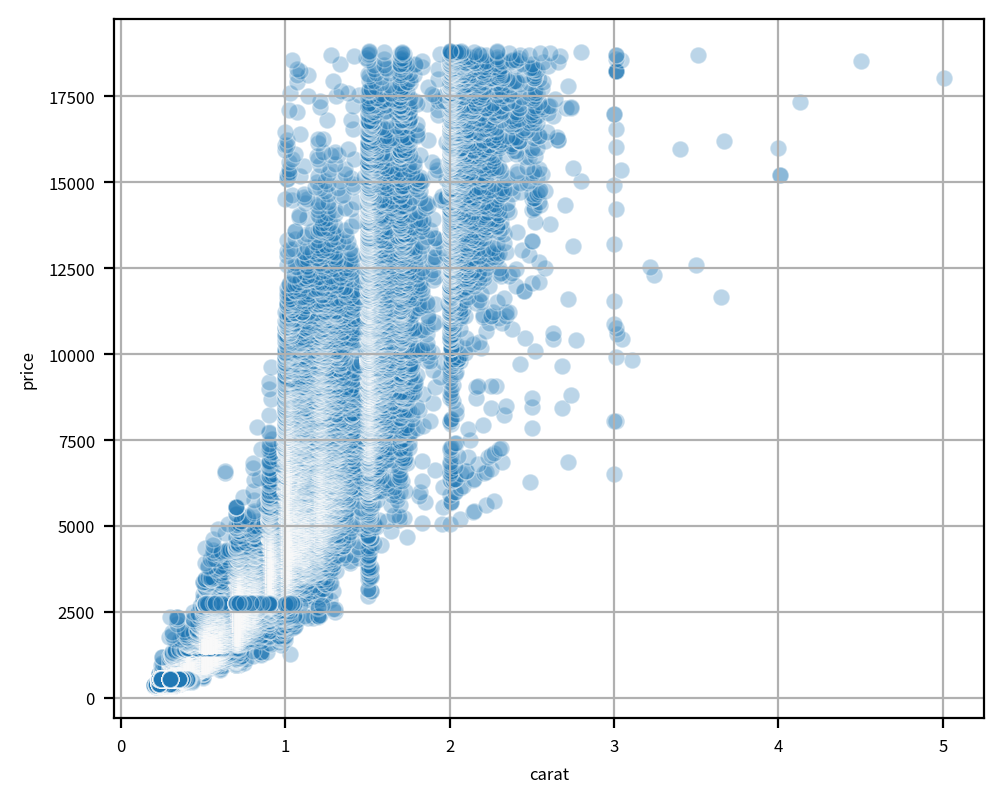

In [16]:
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.scatterplot(data=origin, x="carat", y="price",  alpha=0.3)

# sb.scatterplot(data=pre_df4, x="Longitude", y="Latitude",  alpha=0.3,
#                c=pre_df4['sqrt_MedHouseValue'], cmap=plt.get_cmap('jet'))

ax.grid(True)

plt.tight_layout()
plt.show()


### **[2] price/carat의 그래프 분포**

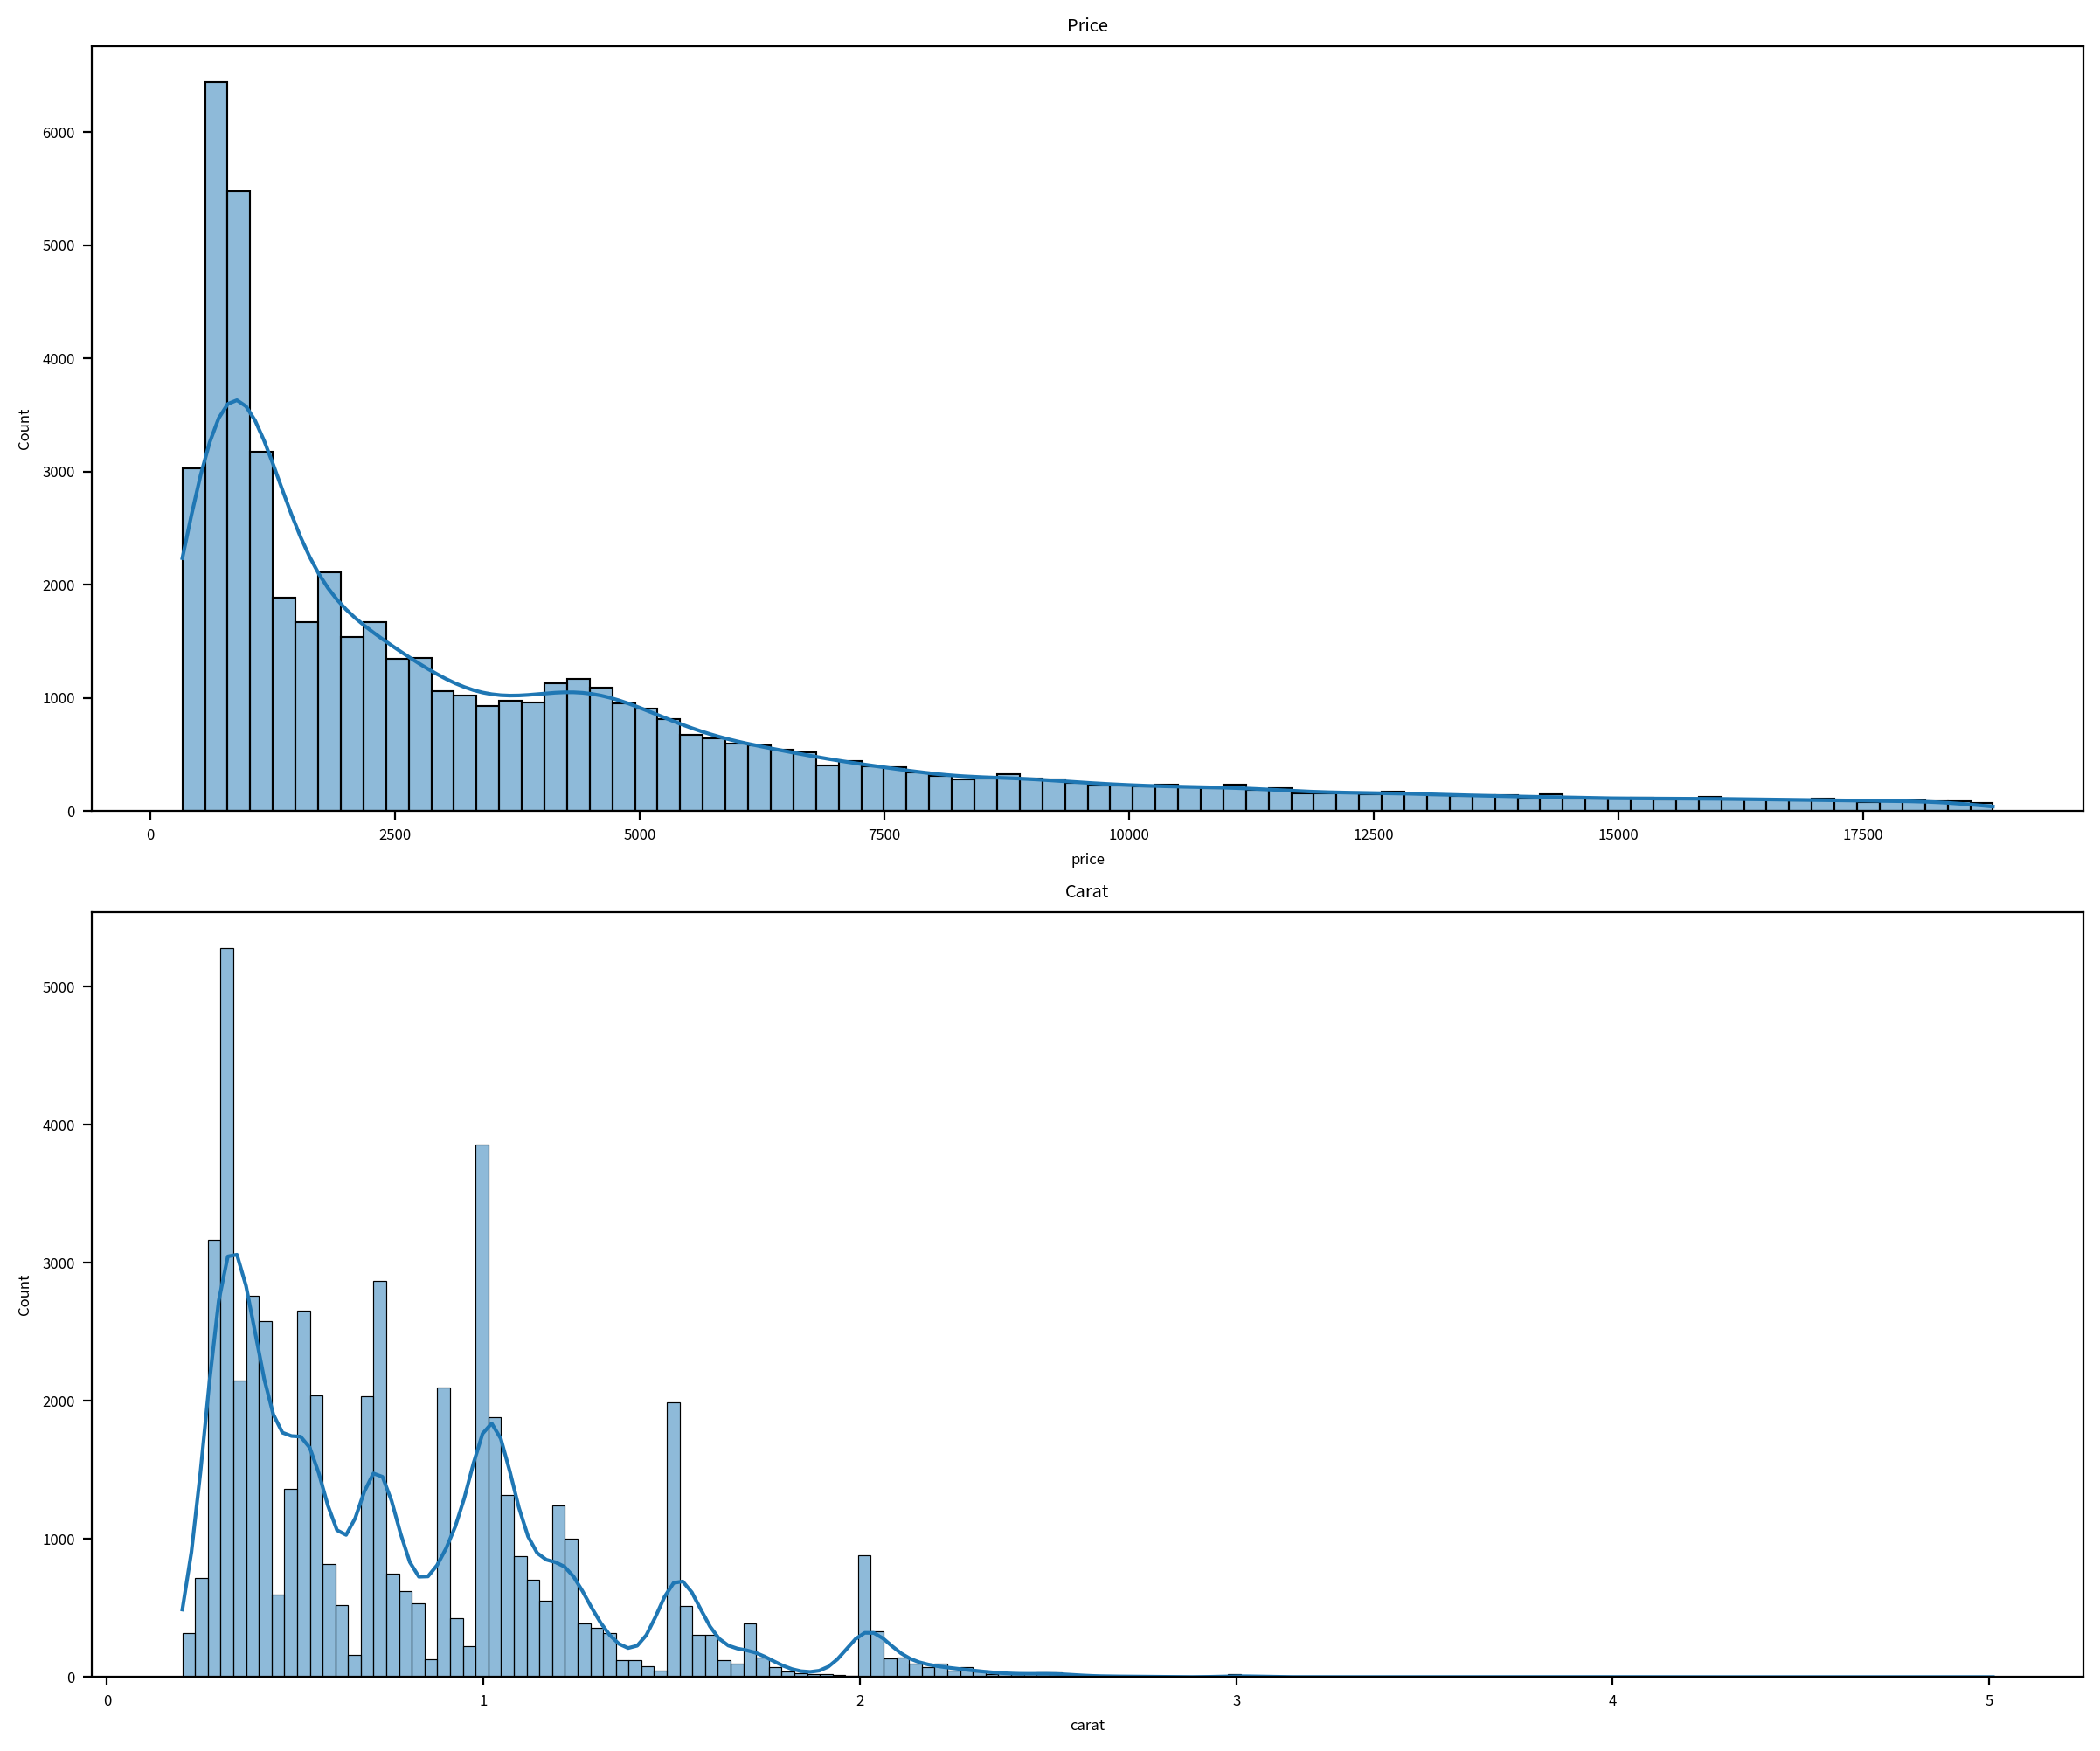

In [17]:
width_px  =1000
height_px =800
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, axes = plt.subplots(2, 1, figsize=(12, 10),dpi=my_dpi)

sb.histplot(origin['price'], kde=True, ax=axes[0])
sb.histplot(origin['carat'], kde=True, ax=axes[1])

axes[0].set_title('Price')
axes[1].set_title('Carat')

plt.tight_layout()
plt.show()

### **미션2_인사이트**
> 
>  price(가격)와 carat(중량) 모두 오른쪽으로 길게 꼬리가 늘어진 편향된 분포 형태를 보인다. 두 변수 모두 낮은 값 구간에  빈도수가 가장 높게 분포되어져 있다.
>
> 이를 통하여 가격이 비싸거나, 중량이 나갈수록 희소하다는 사실을 알 수  있다.
> 
> 또한 price는 17500까지 이어지게 분포되어 있다면, carat는 낮은 값 구간에서 중간 값 구간까지 불규칙한 높낮이로 분포되어 있다.
>
> 해당 결과를 기반으로 전처리 없이 회귀분석을 수행할시 선형성 및 정규성을 위반하여 통계적 유의성이나 신뢰구간을 믿기 어려워질 뿐만 아니라 이상치로 인한 회귀계수의 왜곡이 발생한다. carat의 경우에는 계단 형식의 그래프로 인해 복잡한 관계를 설명할 수 없다.
>
> 로그변환을 통해 정규 분포에 가까워지는지를 확인하거나 Robust Scaler를 통해 중앙값을 0으로 맞출 수 있다. carat의 경우 계단식의 그래프이므로 범주화를 통해 일정 구간으로 나누어 전처리를 시도해볼 수 있다.

## **미션3_"로그 변환은 왜 등장할까?"**
--------------

-------------------------
🧠 어떻게 문제를 풀어볼까나?!
1. 로그변환이 등장하는 이유 : 데이터가 정규성을 충족하지 않을 경우 로그변환을 통해 정규성에 가까워짐
   - log10, log1p
-------------------------

### 1. 로그 변환

In [18]:

zero_df3.copy()

log_df = pd.DataFrame()
log_df['log_price'] = np.log(zero_df3['price'])


log_df['log_carat'] = np.log(zero_df3['carat'])
log_df.head()

log_price  log_carat
0   5.786897  -1.469676
1   5.786897  -1.560648
2   5.789960  -1.469676
3   5.811141  -1.237874
4   5.814131  -1.171183

### 2. 로그 변환 전후 비교

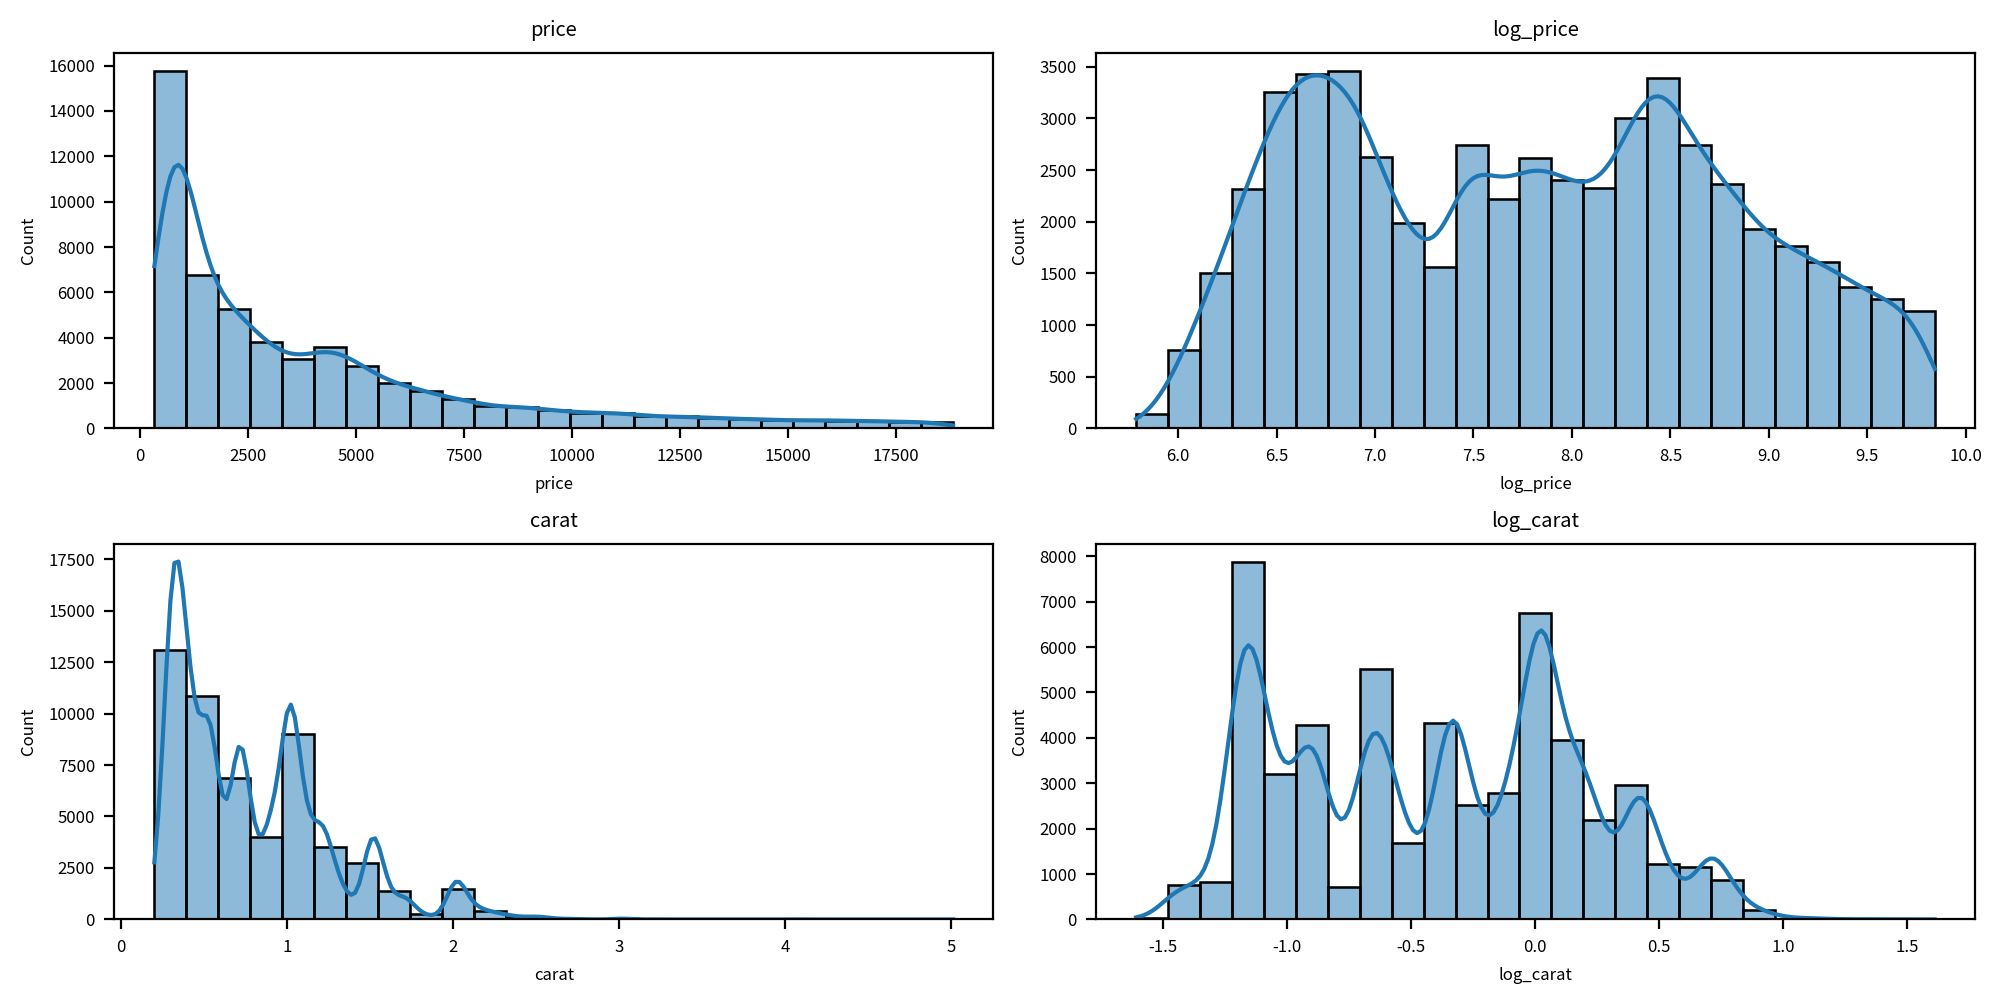

In [19]:
width_px = 2000
height_px = 1000
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=my_dpi)

sb.histplot(zero_df3['price'], kde=True,bins=25, ax=ax[0][0])
sb.histplot(log_df['log_price'],kde=True,bins=25, ax=ax[0][1])
sb.histplot(zero_df3['carat'],kde=True,bins=25, ax=ax[1][0])
sb.histplot(log_df['log_carat'], kde=True,bins=25, ax=ax[1][1])

ax[0][0].set_title('price')
ax[0][1].set_title('log_price')
ax[1][0].set_title('carat')
ax[1][1].set_title('log_carat')


# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

### **[3] carat의 범주화**

#### 1. carat의 범주 확인_ecdfplot

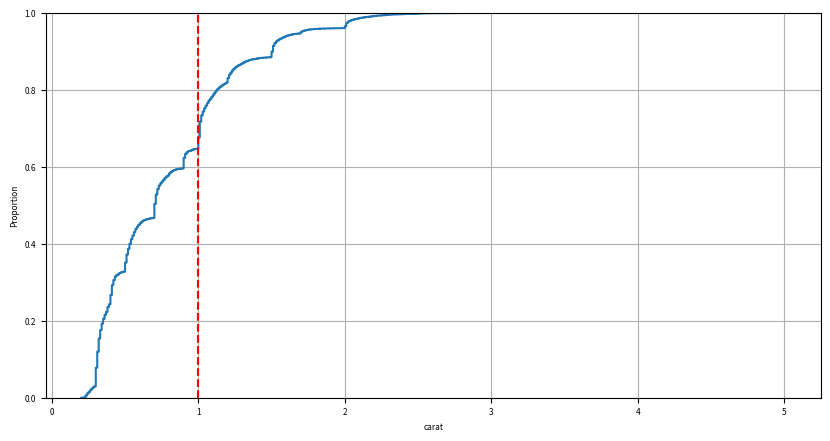

carat
2.65    1
4.13    1
2.71    1
2.59    1
3.51    1
2.67    1
4.50    1
5.01    1
3.11    1
2.77    1
3.05    1
3.02    1
3.65    1
3.24    1
3.22    1
3.50    1
2.70    1
3.40    1
4.00    1
3.67    1
Name: count, dtype: int64


In [20]:
origin['carat'].describe()

plt.figure(figsize=(10, 5))

sb.ecdfplot(data=origin, x='carat')
plt.axvline(1.0, color='r', linestyle='--') # 1캐럿 기준선

plt.grid(True)
plt.show()

# print(origin['carat'].value_counts().head(20))
print(origin['carat'].value_counts().tail(20))

#### 2. carat의 범주구간을 나누고 mapping
- 특정 캐럿 무게는 그 가치 때문에 '마법의 크기' :  1.00캐럿, 1.50캐럿, 그리고 2.00캐럿

In [21]:
bins = [0, 0.5, 1.0, 1.5, 2.0, 5.5]
labels = ['Small', 'Medium', 'Large', 'Very Large', 'Extra Large']
origin['category_carat'] = pd.cut(origin['carat'], bins=bins, labels=labels)

carat_map = {'Small': 1, 'Medium': 2, 'Large': 3, 'Very Large': 4, 'Extra Large': 5}
origin['map_carat'] = origin['category_carat'].map(carat_map).astype(int)

print(origin['map_carat'].value_counts())
origin['map_carat'].unique()

map_carat
1    18932
2    17506
3    12060
4     3553
5     1889
Name: count, dtype: int64


array([1, 2, 3, 4, 5])

#### 3. carat의 범주 시각화

C:\Users\itwill\AppData\Local\Temp\ipykernel_14604\2103477932.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=origin, x='map_carat', y='price', palette='viridis')
C:\Users\itwill\AppData\Local\Temp\ipykernel_14604\2103477932.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=origin, x='map_carat', y='price', palette='muted', alpha=0.5)


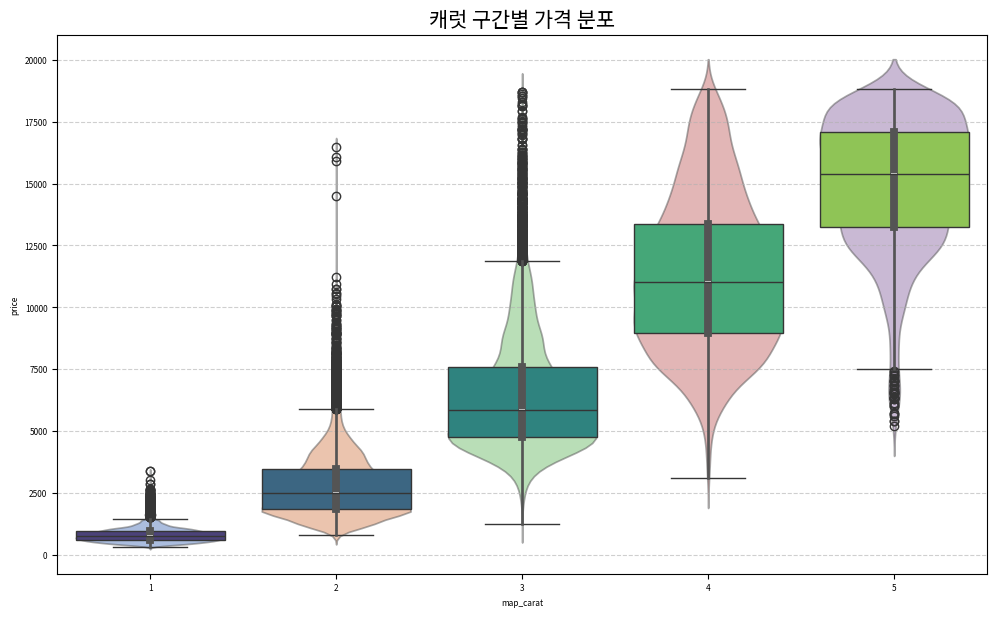

mean   median          std  count
map_carat                                           
1            839.718149    788.0   310.063610  18932
2           2811.342683   2528.0  1302.829337  17506
3           6513.526534   5846.0  2456.438809  12060
4          11321.774838  11040.0  3075.284432   3553
5          14951.250397  15392.0  2703.594528   1889

In [22]:
plt.figure(figsize=(12, 7))

# 1. 박스플롯: 중앙값, 사분위수, 이상치 확인
sb.boxplot(data=origin, x='map_carat', y='price', palette='viridis')

# 2. 개별 데이터의 밀도를 함께 보기 위해 바이올린 플롯을 겹치거나 따로 그릴 수 있습니다.
sb.violinplot(data=origin, x='map_carat', y='price', palette='muted', alpha=0.5)

plt.title('캐럿 구간별 가격 분포', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

# 구간별 가격 통계 요약
price_stats = origin.groupby('map_carat')['price'].agg(['mean', 'median', 'std', 'count'])
price_stats

### **미션3_인사이트**

> price변수의 경우 로그변환 후의 그래프가 고르게 분포되었지만. 정규성을 만족한다고 보기는 어렵다.
> 
> 또한 carat의 경우는 로그변환 이후에도 데이터 분포에 큰 차이가 없다.
>
> 로그변환 전후를 비교해 봤을 때, 정규성을 만족할만한 결과를 도출해내지 못하였다. 
>
> 로그변환을 통해 데이터가 특정 구간에 몰려 있지 않기 때문에 회귀분석에 시도하는 것에는 무리가 없어보인다.
>
>log_carat은 이전보다 왜도가 해결되었지만 여전히 여러 개의 봉우리가 남아있는 것에 의문이 생겼으나 해당 데이터가 가진 고유한 특성임을 확인하였다. 회귀분석의 성능을 높이기 위하여 이후 범주화를 시도해보고자 한다.

In [23]:
zero_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53920 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53920 non-null  int64  
 1   carat    53920 non-null  float64
 2   cut      53920 non-null  object 
 3   color    53920 non-null  object 
 4   clarity  53920 non-null  object 
 5   x        53920 non-null  float64
 6   y        53920 non-null  float64
 7   z        53920 non-null  float64
 8   depth    53920 non-null  float64
 9   table    53920 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [24]:
pre_df_origin = zero_df3.copy()
pre_df_log = log_df[['log_price', 'log_carat']]

pre_df2 = pd.concat([pre_df_origin, pre_df_log], axis=1)
# pre_df2 = pre_df.drop(columns=pre_df.columns[0:3])
pre_df2.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   log_price  log_carat  
0   5.786897  -1.469676  
1   5.786897  -1.560648  
2   5.789960  -1.469676  
3   5.811141  -1.237874  
4   5.814131  -1.171183

## **미션4_"품질 등급은 가격을 얼마나 설명해 줄까?"**
------------------
- cut, color, clarity에 따라 다이아몬드 가격 분포가 어떻게 달라지는지 시각화해 보자.
- 중앙값, 분산, 분포의 겹침 정도를 관찰하며 다음 질문에 답해 보자.
  - 어떤 품질 변수는 가격 차이가 뚜렷한가?, 
  - 어떤 경우에는 등급이 달라도 가격이 크게 겹치는가?
- 숫자보다 패턴과 느낌을 중심으로 정리해 보자.

In [25]:
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

# 높은 등급: 1 -> 낮은 등급: 큰 숫자
cut_order = {'Ideal': 1, 'Premium': 2, 'Very Good': 3, 'Good': 4, 'Fair': 5}
color_order = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7}
clarity_order = {'IF': 1, 'VVS1': 2, 'VVS2': 3, 'VS1': 4, 'VS2': 5, 'SI1': 6, 'SI2': 7, 'I1': 8}

pre_df2['map_cut'] = pre_df2['cut'].map(cut_order)
pre_df2['map_color'] = pre_df2['color'].map(color_order)
pre_df2['map_clarity'] = pre_df2['clarity'].map(clarity_order)


#-------------------
# pre_df2 최종 테이블 생성
order = ['log_price','price','log_carat','carat','map_carat','cut', 'map_cut', 'color', 'map_color', 'clarity', 'map_clarity','x','y','z','depth','table' ]
pre_df2['map_carat'] = origin['map_carat']
pre_df2 = pre_df2[order]
pre_df2.head()


log_price  price  log_carat  carat  map_carat      cut  map_cut color  \
0   5.786897    326  -1.469676   0.23          1    Ideal        1     E   
1   5.786897    326  -1.560648   0.21          1  Premium        2     E   
2   5.789960    327  -1.469676   0.23          1     Good        4     E   
3   5.811141    334  -1.237874   0.29          1  Premium        2     I   
4   5.814131    335  -1.171183   0.31          1     Good        4     J   

   map_color clarity  map_clarity     x     y     z  depth  table  
0          2     SI2            7  3.95  3.98  2.43   61.5   55.0  
1          2     SI1            6  3.89  3.84  2.31   59.8   61.0  
2          2     VS1            4  4.05  4.07  2.31   56.9   65.0  
3          6     VS2            5  4.20  4.23  2.63   62.4   58.0  
4          7     SI2            7  4.34  4.35  2.75   63.3   58.0

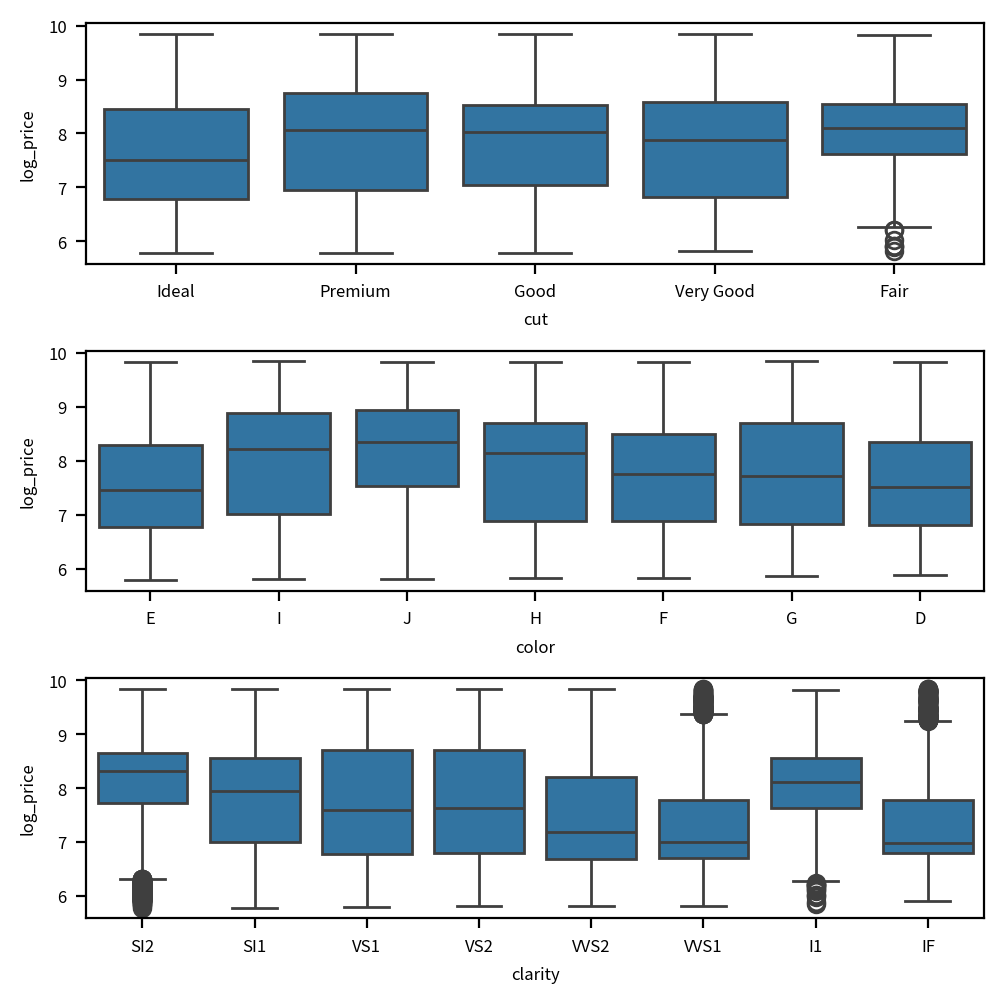

In [26]:
width_px = 1000
height_px = 1000
rows = 3
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=pre_df2, x='cut', y='log_price', ax=ax[0])
sb.boxplot(data=pre_df2, x='color', y='log_price', ax=ax[1])
sb.boxplot(data=pre_df2, x='clarity', y='log_price', ax=ax[2])


plt.tight_layout()
plt.show()
plt.close()

#### **미션4_인사이트**
>
> cut에 따른 등급은 ideal > premium > ~ good> fair 순이다. ideal의 중앙값은 다른 등급에 비해 낮아 보이며 이를 통해 cut가 가격을 결정짖는 요인은 아닌 것으로 보인다.
>
> color의 등급은 D(최고)에서 J(최악)까지 중앙값은 높아지는 경향과 상자크기가 높아지는 것을 알 수 있다.이를 통해 낮은 등급의 경우는 분산이 매우 길어 가격 변동성이 커진다는 것을 알 수 있다.
>
> clarity(투명도)의 중앙값을 보면 I1(최악)에서 IF(최고)로 갈수록 중앙값이 낮아지는 경향을 보이며 이를 통해 투명도에 따라서 가격이 ???????????????
>
> 이를 통하여 color변수가 등급에 따른 가격 상승 경향이 가장 일관되게 나타나며 cut변수는 등급 간의 가격 차이가 거의 없거나 오히려 역전되는 경향을 보인다.clarity의 경우 특정 하위 등급에서 변동이 크므로 특정 구간에서 가격에 미치는 영향력이 달라짐을 확인할 수 있었다.

## **미션5_"Premium 컷은 정말 더 비쌀까?"**
-------
- Premium 컷 다이아몬드는 Ideal 컷보다 평균 가격이 높을까?
- 이를 위해 - 가설을 직접 세우고 - 어떤 검정 방법이 적절한지 고민한 뒤 - 실제로 검정을 수행해 보자.
- 검정 결과를 해석할 때는 “유의하다 / 유의하지 않다”에서 멈추지 말고, 이 차이가 얼마나 의미 있는 차이인
지까지 함께 생각해 보자.

-------------
🧠 어떻게 문제를 풀어볼까나?!

1. 가설 설정 -> 귀무가설, 대립가설
2. 가격에 따른 두 변수들의 평균 가격을 비교하려면? -> 신뢰수준 확인 -> 가설검정 -> 
3. 어떤 검정 방법이 적절할까? -> 데이터가 정규성을 따르지 않음.(맨휘트니U검정), 등분산성도 확인 필요, 
---------------

### 0. 가설 설정
- 귀무가설 : premium컷과 ideal컷의 평균 가격 차이는 없다(가격이 같다.).
- 대립가설 : premium컷과 ideal컷의 평균 가격 차이는 있다(가격이 다르다.).

In [27]:
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
from statannotations.Annotator import Annotator

In [28]:
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
from statannotations.Annotator import Annotator

### 1. 기술통계량 확인

In [29]:
df5= pre_df2[pre_df2['cut'].isin(['Premium', 'Ideal'])]
#df5.head()

pre_df3= df5.groupby('cut')[['log_price']].describe().T
pre_df3

cut                     Ideal       Premium
log_price count  21548.000000  13780.000000
          mean       7.639297      7.949996
          std        0.992276      1.029867
          min        5.786897      5.786897
          25%        6.777647      6.952729
          50%        7.500806      8.065265
          75%        8.450626      8.746756
          max        9.841931      9.842835

### 2. 신뢰구간 확인

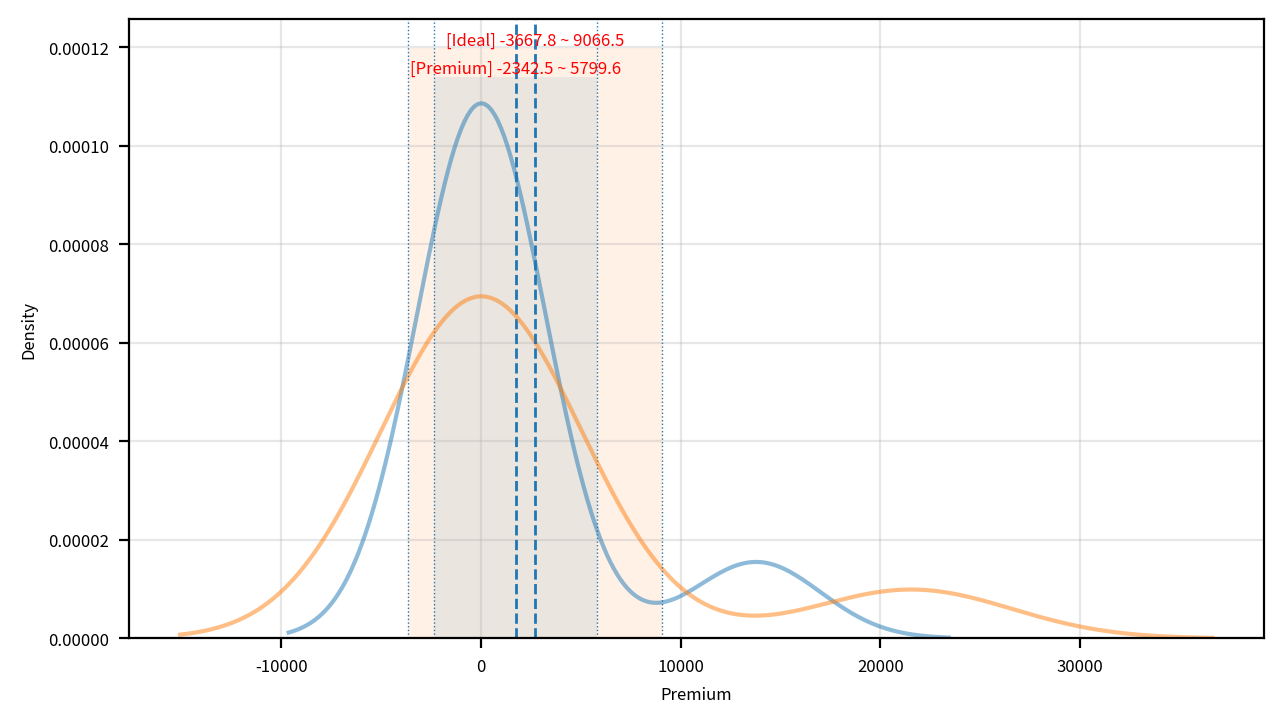

In [30]:
data = pre_df3[['Premium', 'Ideal']]         # 확인할 데이터

 # 1) 그래프 초기화
width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()                         
    clevel = 0.95
    dof = len(data[c]) - 1
    sp_mean = data[c].mean()                    
    sp_std = data[c].std(ddof=1) 
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})
    
# 그래프 꾸미기
ax.grid(True,alpha=0.3)

# 4) 출력
plt.tight_layout()      
plt.show()              
plt.close()             

> Premium과 Ideal의 커널밀도함수 그래프의 모양이 정규분포를 띄고 있지 않지만 두 그룹의 데이터 분포는 비슷하다고 할 수 있다.
> 도한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수있다.
>
> Premium과 Ideal의 커널밀도함수 그래프 모두 우편향된 비정규분포 형태를 띄며 오른쪽으로 꼬리가 길어지는 모양이다.
> 또한 두 그룹 모두 신뢰구간 내에 표본평균이 위치하며, 두 그룹의 신뢰구간이 상당 부분 겹치고 있으나 쳥균선의 위치를 통해 Premium의 가격 중심이 Ideal보다 상대적으로 고가에 형성되어 있음을 알 수 있다.

### 3. 정규성 검정
 - 신뢰구간에서도 대략적으로 정규성을 확인할 수 있지만 정확한 수치를 통하여 검정하고자 함

In [31]:
data = pre_df3[['Premium', 'Ideal']]           

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

#   
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"
 # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*data.values.T)                 
# 모든 컬럼의 데이터를 한번에 전달
    else:
        n = "Levene"
# 정규성을 충족하지 않을 경우의 검정 방법
        s, p = levene(*data.values.T, center='median')  # 모든 컬럼의 데이터를 한번에 전달
    
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('field')
report_df

statistic   p-value  result
field                               
Premium  22.957426  0.000010   False
Ideal    22.957440  0.000010   False
Levene    0.092331  0.765704    True

### 4. 양측검정, 단측검정

In [32]:
alternatives = ['two-sided', 'less', 'greater']

for alt in alternatives:
    # 데이터 추출 (Premium vs Ideal)
    group_a = pre_df2[pre_df2['cut'] == 'Premium']['log_price']
    group_b = pre_df2[pre_df2['cut'] == 'Ideal']['log_price']
    
    # 검정 수행
    s, p = mannwhitneyu(group_a, group_b, alternative=alt)
    
    # 결과 출력
    h_type = "대립" if p <= 0.05 else "귀무"
    print(f"[{alt:9}] statistic: {s:10.3f}, p-value: {p:.3f}, {h_type}가설 채택")

[two-sided] statistic: 174078470.500, p-value: 0.000, 대립가설 채택
[less     ] statistic: 174078470.500, p-value: 1.000, 귀무가설 채택
[greater  ] statistic: 174078470.500, p-value: 0.000, 대립가설 채택


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Premium vs. Ideal: Mann-Whitney-Wilcoxon test two-sided, P_val:7.525e-01 U_stat=3.550e+01


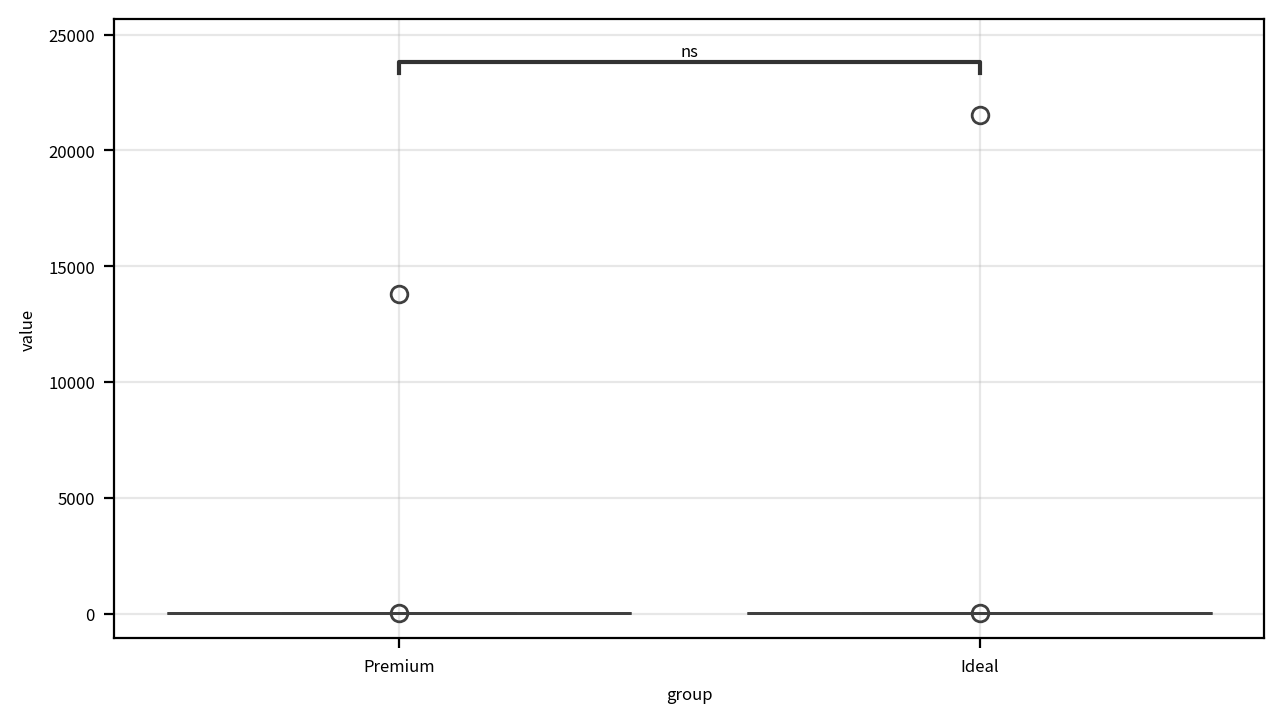

In [33]:
fields = ['Premium', 'Ideal']
filter_data = pre_df3[['Premium', 'Ideal']]   
df = melt(filter_data, value_vars=fields, var_name='group', value_name='value')

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=df, x='group', y='value', hue='group')
annotator = Annotator(ax, data=df, x='group', y='value', pairs=[('Premium', 'Ideal')])
annotator.configure(test='Mann-Whitney')
annotator.apply_and_annotate()

ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

1. 가설 검정 최종 결과
- 통계적 유의성 부재: Premium 컷과 Ideal 컷 간의 독립표본 t-검정 결과, p-value가 0.9236으로 나타났습니다. 
- 이는 유의수준 0.05보다 훨씬 높으므로, 두 그룹 간의 가격 차이가 있다는 가설은 통계적으로 유의미하지 않습니다.
- 
- 검정 결과 기호: 박스 플롯 상단의 'ns' 표시는 'Not Significant'를 의미하며, 두 집단의 평균 차이가 우연에 의해 발생했을 가능성이 매우 높음을 나타냅니다.
  
1. 정규성 및 등분산성 검정 결과
- 정규성 충족: Premium(p=0.213) 및 Ideal(p=0.201) 그룹 모두 p > 0.05로, 데이터가 정규 분포를 따른다는 통계적 근거를 확보했습니다.
- 등분산성 충족: Bartlett 검정 결과 p=0.514로 나타나, 두 그룹의 분산이 동일함이 확인되었습니다. 이로 인해 equal_var=True를 가정한 t-검정의 신뢰도가 확보되었습니다.
  
1. 데이터 분포의 객관적 특징
- 중앙값 비교: Premium 그룹의 중앙값이 Ideal 그룹보다 시각적으로 약간 높게 위치해 있지만, 박스 플롯의 몸통(IQR)이 대부분 겹쳐 있어 실질적인 가격 대역은 매우 유사합니다.
- 극단적 이상치: 두 그룹 모두 가격 20,000 이상 영역에서 개별적인 이상치(Outliers)가 관찰됩니다.
  
1. 미션 5에 대한 최종 결론
- 결론: 통계적 검정 결과, "Premium 컷 다이아몬드가 Ideal 컷보다 더 비싸다"는 주장은 근거가 부족합니다.
- 의미 해석: 비록 Premium 컷이 세공 등급상 Ideal보다 낮음에도 불구하고 가격 차이가 나지 않는 현상은,
  가격 결정에 '컷' 외의 다른 요인(예: 무게, 색상 등)이 복합적으로 작용하여 두 등급 간의 가격 차이를 상쇄시키고 있음을 시사합니다.

## **미션6_"모든 컷은 서로 다를까?"**
------------

- 이번에는 컷 등급 전체를 놓고 생각해 보자.
- cut에 따른 가격 차이가 전반적으로 존재하는지 분산분석으로 확인해 보고, 차이가 있다면 어떤 컷들 사이에서 차이가 발생하는지 사후검정을 통해 살펴보자.
- 이 결과를 '가격 서열표'처럼 정리해 보는 것도 좋다.
  
> 전체 차이 확인(ANOVA)에서 그치지 않고, 어떤 조합에서 차이가 나는지 구체화하는 연습. 결과를 서열/지도처럼 정리

In [34]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

-------------
🧠 어떻게 문제를 풀어볼까나?!

1. cut에 따른 가격 차이가 전반적으로 존재하는지 분산분석으로 확인 -> 일원분산분석(평균차이) -> 사후검정
2. 결과를 가격 서열표로 정리 
---------------

- 귀무가설 : 모든 컷 등급 간의 평균 가격은 차이가 없다.(같다)
- 대립가설 : 모든 컷 등급 간의 평균 가격은 차이가 있다.(가격이 다르다)

### 1. 데이터 분포 확인

Mean Price  Lower Bound  Upper Bound  Sample Size(n)
Cut Grade                                                      
Ideal            7.64         7.63         7.65           21548
Premium          7.95         7.93         7.97           13780
Very Good        7.80         7.78         7.82           12081
Good             7.84         7.81         7.87            4902
Fair             8.09         8.06         8.13            1609

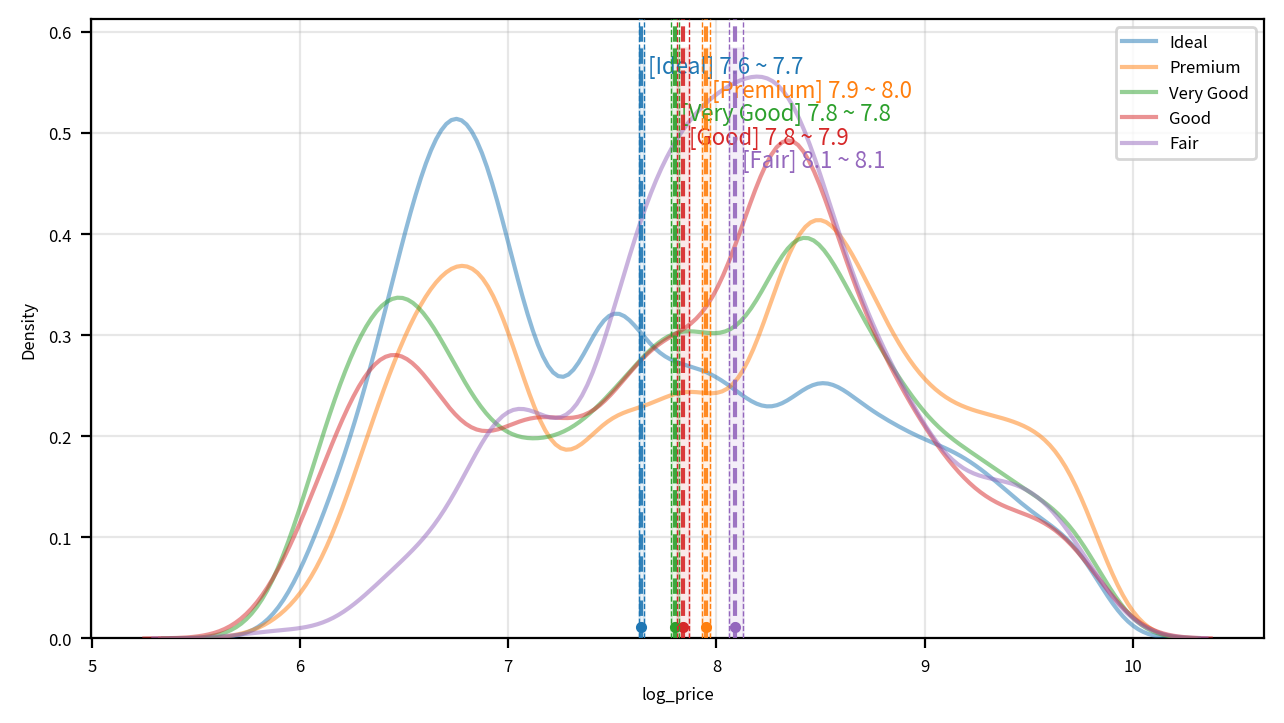

In [35]:
color_map = {'Ideal': '#1f77b4', 'Premium': '#ff7f0e', 'Very Good': '#2ca02c', 'Good': '#d62728', 'Fair': '#9467bd'}
cuts = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

results = []

width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(cuts):
    subset = pre_df2[pre_df2['cut'] == v]['log_price']
    n = len(subset)

    sb.kdeplot(subset, fill=False, alpha=0.5, label=v, ax=ax, color=color_map[v], zorder=3)

    clevel = 0.95
    dof = n - 1
    sp_mean = subset.mean()
    sp_std = subset.std(ddof=1)
    sp_std_error = sp_std / np.sqrt(n)

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    results.append({
        'Cut Grade': v,
        'Mean Price': round(sp_mean, 2),
        'Lower Bound': round(cmin, 2),
        'Upper Bound': round(cmax, 2),
        'Sample Size(n)': n
    })

ymin, ymax = ax.get_ylim()

for i, v in enumerate(cuts):
    res = next(item for item in results if item['Cut Grade'] == v)
    cmin, cmax, sp_mean = res['Lower Bound'], res['Upper Bound'], res['Mean Price']
    
    ax.axvline(cmin, linestyle='--', linewidth=0.5, color=color_map[v], zorder=6)
    ax.axvline(cmax, linestyle='--', linewidth=0.5, color=color_map[v], zorder=6)
    ax.axvline(sp_mean, linestyle='--', linewidth=1.5, alpha=0.9, color=color_map[v], zorder=7)
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1, color=color_map[v], zorder=1)
    
    text_y = ymax * (0.95 - (i * 0.04))
    ax.text((cmax + cmin) / 2 + 0.03, text_y, f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
            horizontalalignment="left", verticalalignment="bottom",
            fontdict={"size": 8, "color": color_map[v]})
    ax.plot(sp_mean, ymax * 0.02, marker='o', color=color_map[v], markersize=3, zorder=5)

ci_table = pd.DataFrame(results).set_index('Cut Grade')
display(ci_table)

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

### 2. 정규성, 등분산성 검정

In [36]:
cuts = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
col = 'log_price'

# 검정을 위한 데이터 그룹화 (각 등급별 가격 리스트 생성)
data_groups = [pre_df2[pre_df2['cut'] == c][col] for c in cuts]

report = []
normal_dist = True

# 1. 각 등급별 정규성 검정
for i, c in enumerate(cuts):
    s, p = normaltest(data_groups[i])
    
    # 유의수준 0.05 기준 정규성 판정
    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    # 하나라도 정규성을 충족하지 않으면 전체를 비정규분포로 간주
    normal_dist = normal_dist and normalize

# 2. 등분산성 확인 (변수가 두 개 이상이므로 실행)
if len(data_groups) > 1:
    if normal_dist:
        n = "Bartlett"
        # 모든 그룹이 정규성을 충족할 경우
        s, p = bartlett(*data_groups)
    else:
        n = "Levene"
        # 하나라도 정규성을 충족하지 못할 경우 (더 보수적인 검정)
        s, p = levene(*data_groups, center='median')
        
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

# 결과 출력
report_df = pd.DataFrame(report).set_index('field')
report_df



statistic        p-value  result
field                                        
Ideal      4631.300567   0.000000e+00   False
Premium    9971.943330   0.000000e+00   False
Very Good  4704.114948   0.000000e+00   False
Good        709.824985  7.302353e-155   False
Fair          5.576223   6.153730e-02    True
Levene      122.580235  2.492832e-104   False

In [37]:
p

np.float64(2.492831970820981e-104)

> Fair은 유의수준 0.05이며 정규분포를 따른다. 이에 반해 다른 4개의 등급은  정규분포를 따르지 않는다
>
> Levene는 여러 그룹 간의 분산이 동일한지 확인하는 검정이다. 해당 결과를 통하여 모든 그룹의 분산이 다르다(이분산성)

### 3. 일원분산분석(One-Way ANOVA)

In [38]:
anova_df = pre_df2[['cut', 'log_price']].copy()
anova_df

cut  log_price
0          Ideal   5.786897
1        Premium   5.786897
2           Good   5.789960
3        Premium   5.811141
4           Good   5.814131
...          ...        ...
53935      Ideal   7.921898
53936       Good   7.921898
53937  Very Good   7.921898
53938    Premium   7.921898
53939      Ideal   7.921898

[53920 rows x 2 columns]

In [39]:
# spicy 패키지
g1 = anova_df[anova_df['cut'] == 'Ideal']['log_price']
g2 = anova_df[anova_df['cut'] == 'Premium']['log_price']
g3 = anova_df[anova_df['cut'] == 'Very Good']['log_price']
g4 = anova_df[anova_df['cut'] == 'Good']['log_price']
g5 = anova_df[anova_df['cut'] == 'Fair']['log_price']

s, p = f_oneway(g1, g2, g3, g4, g5, equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 273.943, p-value: 0.000, 대립가설 채택'

In [40]:
# pingouin 패키지_등분산성 미충족(welch)
anova_result=welch_anova(data=pre_df2, dv='log_price', between='cut')

s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립"if p <= 0.05 else"귀무")


'statistic: 273.943, p-value: 0.000, 대립가설 채택'

### 4. 사후검정(post hoc)

In [41]:
print("..= Games-Howell ..=")
hoc_df = pairwise_gameshowell(data=pre_df2, dv='log_price', between='cut')
pd.options.display.float_format = '{:.3f}'.format
hoc_df

..= Games-Howell ..=


A          B  mean(A)  mean(B)   diff    se       T        df  pval  \
0     Fair       Good    8.093    7.842  0.251 0.024  10.579  3475.310 0.000   
1     Fair      Ideal    8.093    7.639  0.454 0.020  22.391  2033.506 0.000   
2     Fair    Premium    8.093    7.950  0.143 0.021   6.804  2345.634 0.000   
3     Fair  Very Good    8.093    7.799  0.294 0.021  13.818  2469.220 0.000   
4     Good      Ideal    7.842    7.639  0.203 0.016  13.047  7354.842 0.000   
5     Good    Premium    7.842    7.950 -0.108 0.017  -6.509  9001.062 0.000   
6     Good  Very Good    7.842    7.799  0.044 0.017   2.589  9554.904 0.072   
7    Ideal    Premium    7.639    7.950 -0.311 0.011 -28.053 28558.963 0.000   
8    Ideal  Very Good    7.639    7.799 -0.159 0.012 -13.722 24097.018 0.000   
9  Premium  Very Good    7.950    7.799  0.151 0.013  11.749 25369.321 0.000   

   hedges  
0   0.269  
1   0.464  
2   0.142  
3   0.292  
4   0.205  
5  -0.106  
6   0.043  
7  -0.309  
8  -0.158  
9   0.146

### **미션6_인사이트**
>kdeplot를 보면 정규성, 등분산성을 확인할 결과 cut 등급별 가격 차이는 정규성과  등분산성을 모두 충족하지 않는다. 이에 일원분산분석과 Games-Howel 사후검정 결과, log_price와 cut의 가격 차이는 통계적으로 유의하였다. 
>
> 대부분의 컷 등급 쌍에서 pval < 0.05로 나타나, 등급 간 평균 로그 가격의 유의한 차이가 명확히 발견되었다.
>
> Fair 등급은 비교 대상인 Good, Ideal, Premium, Very Good 모든 등급과의 비교에서 평균 로그 가격이 유의미하게 높은 것으로 나타났다. 특히 Ideal 등급과의 차이가 가장 컸으며(diff = 0.45, pval = 0.000), 이는 통계적 기준을 매우 강력하게 충족한다.
>
> Good과 Very Good 비교에서는 pval = 0.068로 나타나 유의수준 0.05 기준에서 통계적으로 유의한 차이가 발견되지 않았다. 두 그룹 사이의 평균 차이(diff = 0.04)는 표본 내 자연스러운 변동 범위로 볼 수 있다.
>
> Ideal 등급은 다른 모든 등급(Fair, Good, Premium, Very Good)과 비교했을 때 평균 로그 가격이 가장 낮았으며, 모든 조합에서 유의미한 차이(pval = 0.000)를 보였다.

## **미션7_"품질 요인들은 서로 영향을 주고받을까?"**
--------
- 컷(cut)과 색(color), 혹은 컷과 투명도(clarity)를 함께 고려하면 가격 구조가 달라질까?
- 이원 분산분석을 통해 각각의 요인이 가격에 미치는 영향. 두 요인이 함께 작용할 때의 효과를 구분해 보자.
- 결과를 해석할 때는 "상호작용이 있다/없다"를 넘어 그 의미가 무엇인지를 설명해 보자.
> 요인들이 단독으로만 작용하지 않을 수 있음을 체험시키려는 단계. 상호작용이 의미하는 바를 말로 풀어내는 것이 핵심

-------------
🧠 어떻게 문제를 풀어볼까나?!

1. 컷과 색, 컷과 투명도를 함께 고려
2. 이원분산분석
---------------

In [42]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

### 1. 데이터 분포 시각화_가격에 따른 컷과 색

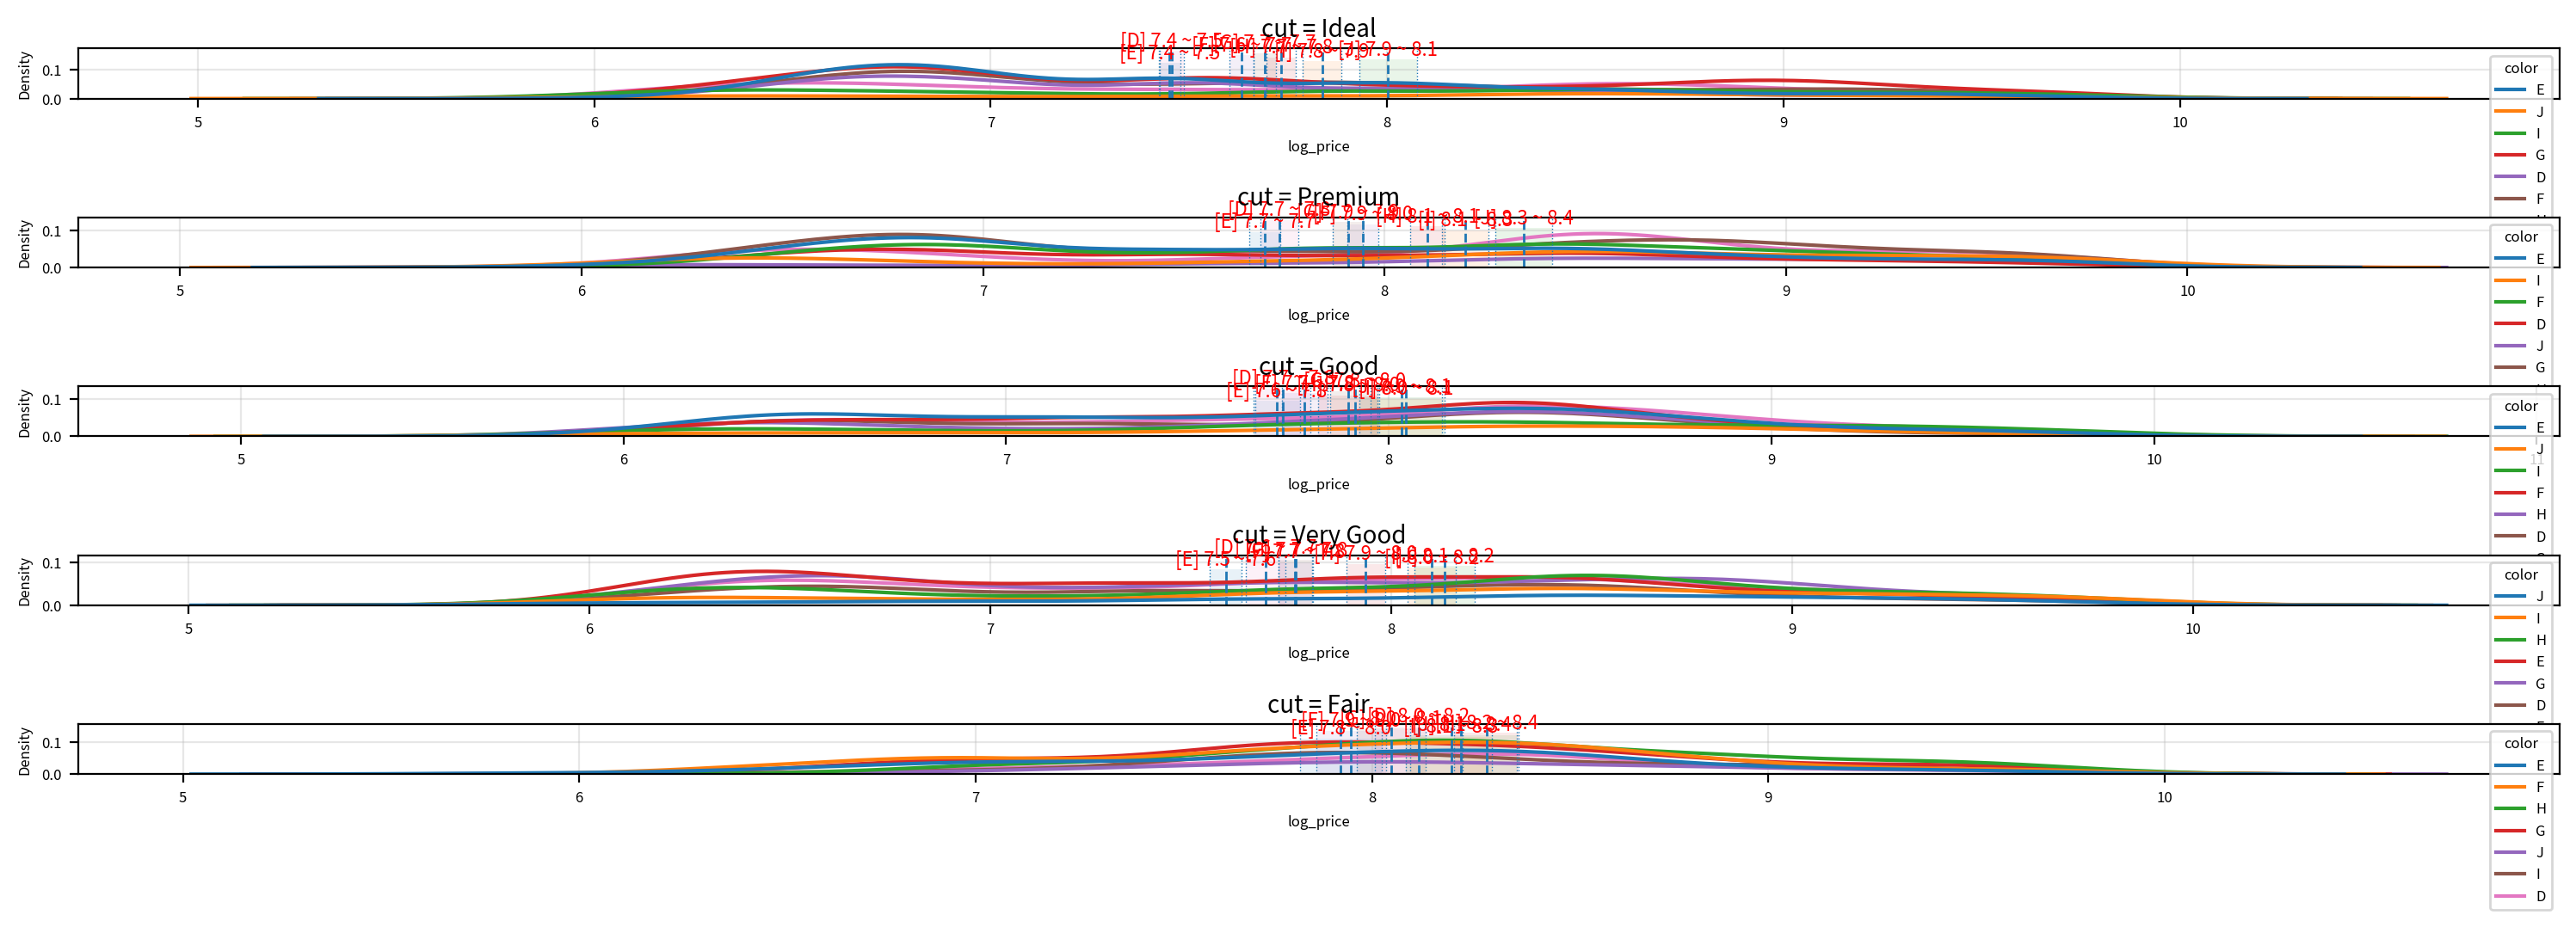

In [43]:
field = 'log_price'                 #⚠️수치형 변수만
group_field = 'cut'
hue_field = 'color'

# 시각화 할 필드만 원본 데이터에서 추출
data = pre_df2[[field, group_field, hue_field]]
group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
width_px  = 3000            
height_px = 1000* rows  
rows = group_count 
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
axes = axes.flatten()

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=axes[i])
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
    # 신뢰구간
        max= temp_sub[field].max()                         # 최대값
        clevel =0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준

        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        axes[i].axvline(cmin, linestyle=':', linewidth=0.5)
        axes[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = axes[i].get_ylim()
        axes[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        axes[i].axvline(sp_mean, linestyle='--', linewidth=1)
        
        # 텍스트 그리기
        axes[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 8, "color": "red"})

plt.tight_layout()      
plt.show()              
plt.close() 

> 다이아몬드 등급 간의 가격 차이는 명확하지만, 유독 Good과 Very Good 등급만큼은 가격 측면에서 통계적으로 유사한 성격을 띠고 있습니다.

### 2. 데이터 분포 시각화_가격에 따른 컷과 투명도

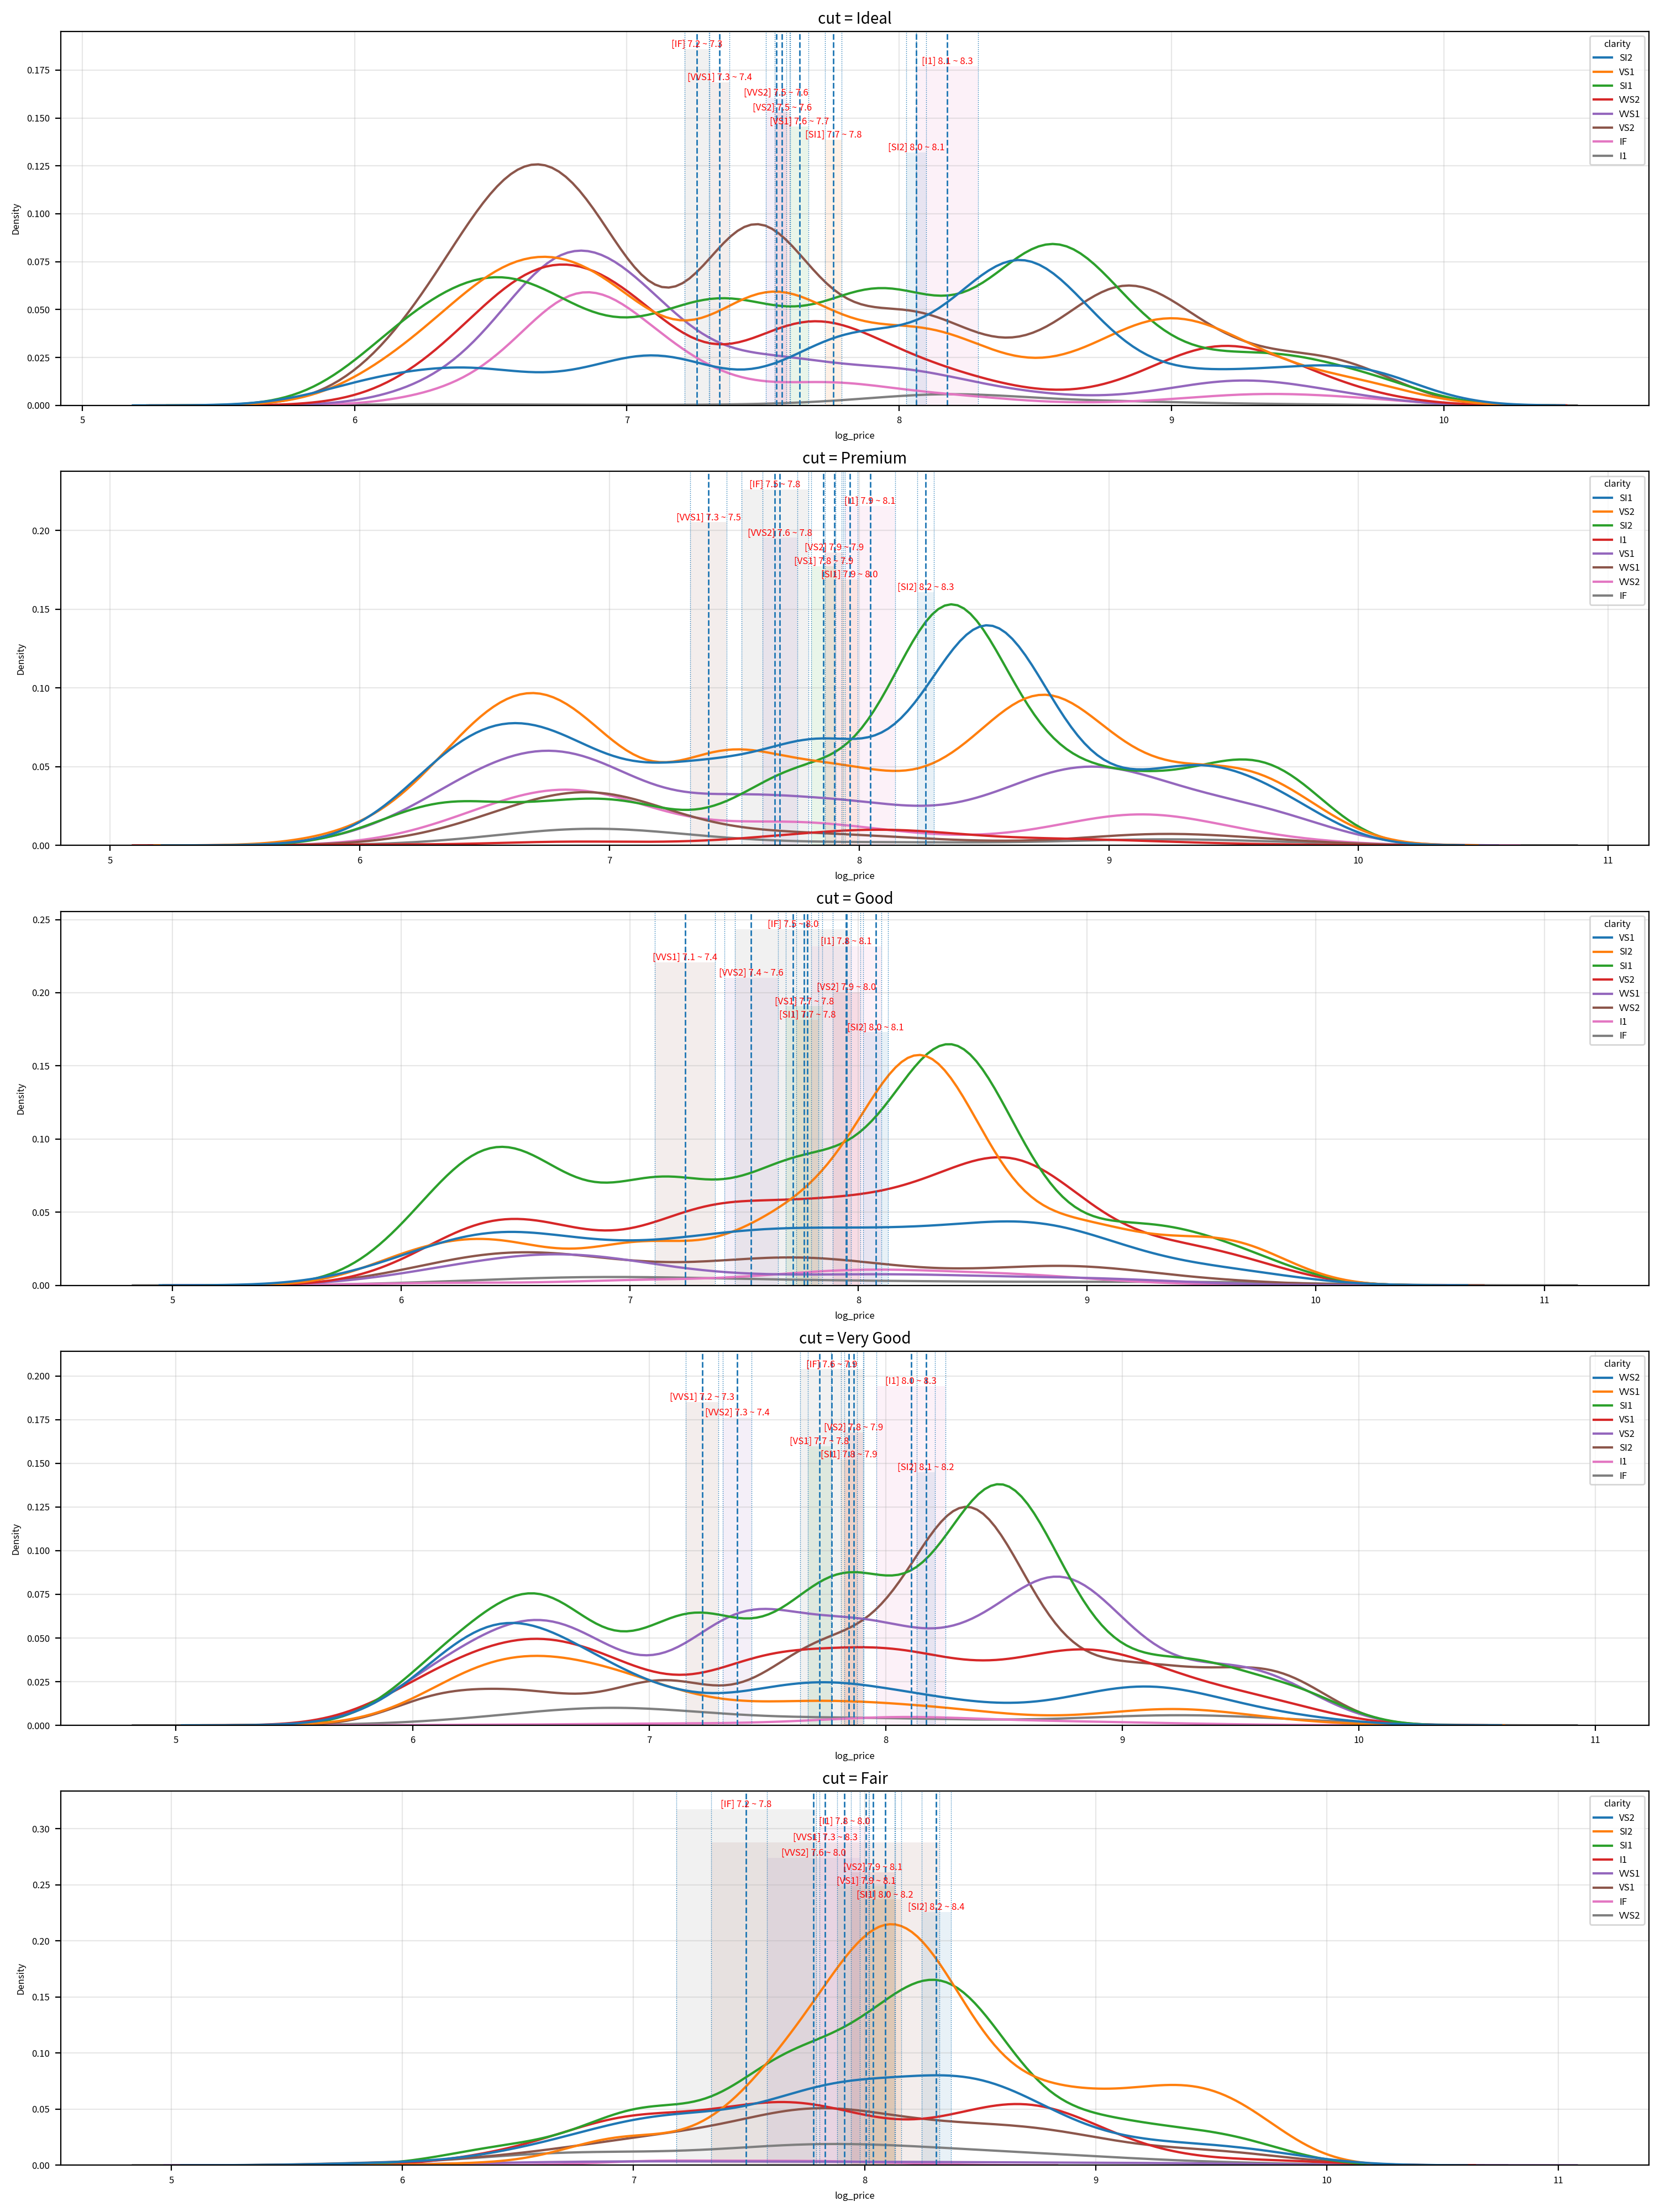

In [44]:
field = 'log_price'                 #⚠️수치형 변수만
group_field = 'cut'
hue_field = 'clarity'

# 시각화 할 필드만 원본 데이터에서 추출
data = pre_df2[[field, group_field, hue_field]]
group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
width_px  = 3000 * cols             
height_px = 800* rows  
rows = group_count 
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
axes = axes.flatten()

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=axes[i])
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
    # 신뢰구간
        max= temp_sub[field].max()                         # 최대값
        clevel =0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준

        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        axes[i].axvline(cmin, linestyle=':', linewidth=0.5)
        axes[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = axes[i].get_ylim()
        axes[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        axes[i].axvline(sp_mean, linestyle='--', linewidth=1)
        
        # 텍스트 그리기
        axes[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

plt.tight_layout()      
plt.show()              
plt.close() 

In [45]:
# 컷과 색상에 따른 log_price의 평균 수치 확인
# 로그변환
pivot_table1 = pre_df2.pivot_table(values='log_price', index='cut', columns='color', aggfunc='mean')

# print("--- [컷 x 색깔별 log_price 평균 수치] ---")
# pivot_table1 = np.expm1(pivot_table).round(2)   #로그 -> 실제 달러 가격
pivot_table1

color         D     E     F     G     H     I     J
cut                                                
Fair      8.118 7.921 7.947 8.048 8.289 8.200 8.225
Good      7.724 7.707 7.780 7.911 7.893 8.046 8.034
Ideal     7.457 7.451 7.632 7.691 7.732 7.835 8.002
Premium   7.738 7.702 7.946 7.909 8.107 8.201 8.346
Very Good 7.686 7.587 7.760 7.762 7.937 8.101 8.134

> 색상 등급이 낮아질수록(D → J) 평균 가격 상승 -> Fair등급에서 D는 8.118, J는 8.226
>
> 같은 색상 내에서는 Premium이나 Fair의 로그 가격이 Ideal보다 높은 경우가 많다.
> 
> Ideal은 주로 작은 다이아몬드에 정교하게 적용되는 반면, 낮은 컷은 알이 큰 다이아몬드에서 발견되는 경향이 반영된 결과로 보인다.

In [46]:
# 컷과 투명도에 따른 log_price의 평균 수치 확인
pivot_table2 = pre_df2.pivot_table(values='log_price', index='cut', columns='clarity', aggfunc='mean')

# print("--- [컷 x 투명도별 log_price 평균 수치] ---")
# pivot_table2 = np.expm1(pivot_table).round(2)   #로그 -> 실제 달러 가격
pivot_table2

clarity      I1    IF   SI1   SI2   VS1   VS2  VVS1  VVS2
cut                                                      
Fair      7.912 7.487 8.088 8.310 8.006 8.036 7.829 7.779
Good      7.947 7.715 7.776 8.076 7.763 7.947 7.242 7.531
Ideal     8.176 7.256 7.758 8.063 7.633 7.570 7.341 7.549
Premium   8.044 7.663 7.962 8.266 7.857 7.900 7.397 7.682
Very Good 8.107 7.773 7.844 8.170 7.720 7.865 7.224 7.373

> (투명도 역설)가장 등급이 낮은 I1의 로그 가격이 최상급인 IF나 VVS1보다 눈에 띄게 높다. -> Ideal 컷에서 I1은 8.177, IF는 7.257
>
> 즉, 투명도가 낮은 다이아몬드의 평균 가격이 더 높은 이유는, 투명도가 희생되더라도 크기(Carat)가 압도적으로 큰 개체들이 평균치를 끌어올리고 있기 때문입니다.

### 3. 분산분석의 가정 확인

In [47]:
data = pre_df2.copy()
xname = ['cut', 'color']
yname = 'log_price'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)
        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df


statistic  p-value  result
field                                   
Ideal, E        310.449    0.000   False
Ideal, I       2720.496    0.000   False
Ideal, J        258.513    0.000   False
Ideal, H       4463.144    0.000   False
Ideal, F        526.216    0.000   False
Ideal, G       2433.025    0.000   False
Ideal, D        213.568    0.000   False
Premium, E      358.024    0.000   False
Premium, I      305.336    0.000   False
Premium, J       65.006    0.000   False
Premium, H      634.470    0.000   False
Premium, F      843.682    0.000   False
Premium, G    15249.897    0.000   False
Premium, D      413.864    0.000   False
Good, E         182.640    0.000   False
Good, I          65.876    0.000   False
Good, J          20.611    0.000   False
Good, H         111.027    0.000   False
Good, F          56.996    0.000   False
Good, G         125.004    0.000   False
Good, D         151.547    0.000   False
Very Good, E    651.979    0.000   False
Very Good, I    120.031    0.000   False
Very Good, J     47.256    0.000   False
Very Good, H    495.600    0.000   False
Very Good, F    608.048    0.000   False
Very Good, G   1660.297    0.000   False
Very Good, D    388.077    0.000   False
Fair, E           1.963    0.375    True
Fair, I           4.053    0.132    True
Fair, J           0.003    0.998    True
Fair, H           4.840    0.089    True
Fair, F           5.196    0.074    True
Fair, G           3.323    0.190    True
Fair, D           0.880    0.644    True
Levene           39.521    0.000   False

### **미션7_인사이트**

> 가장 눈에 띄는 현상은 품질이 낮을수록 로그 가격 평균이 높게 형성되는 역설적 상황.
>
> Color(색상): 가장 좋은 등급인 'D'보다 가장 낮은 등급인 'J'의 로그 가격 평균이 모든 컷 등급에서 더 높게 나타난다. -> Premium 컷에서 D는 7.740, J는 8.347
>
> Clarity: 최상급인 'IF' 등급보다 최하급인 'I1' 등급의 로그 가격 평균이 압도적으로 높다. -> Ideal 컷에서 IF는 7.257, I1은 8.177
>
> 즉, 실제 시장 가치와 반대되는 결과처럼 보이지만, carat의 영향때문에 품질이 낮은 다이아몬드들은 대개 알이 매우 크기 때문에 평균 가격이 높게 측정된 것으로 보인다.
>
> 대부분의 그룹에서 p-value가 0으로 나타나며 이는 귀무가설을 기각하고 대립가설을 채택한다. 
> 이는 각 등급 조합별로 로그 가격의 차이가 통계적으로 매우 유의미하게 존재한다는 의미이다.
>
> 가장 하위 등급인 Fair 내에서는 p-vlaue가 0.05보다 큰 조합이 존재한다.  이를 통해 color에 따른 로그 가격의 차이가 통계적으로 유의하지 않다는 것을 의미하며 Fair컷 다이아몬드들은 색상에 상관없이 비슷한 가격대를 형성하고 있다는 가능성이 크다.
>
### **미션7_종합 인사이트**
> 품질 등급(cut, clarity) 자체는 평균 가격에 반비례하는 모습을 보인다.
>
> Fair 등급을 제외한 모든 품질 조합은 가격 결정에 있어 서로 유의미하게 다른 영향을 미치고 있다.
>
> 즉, 품질 요인만으로는 가격을 설명할 수 없으며, carat이 가격을 결정하는 가장 강력한 변수일 것이라는 가설을 입증

### 4. 표준 분산분석 시행

In [48]:
xname = ['cut', 'color']
yname = 'price'
pg_anova = anova(data=origin, dv=yname, between=xname)
pg_anova

Source               SS        DF             MS       F  p-unc   np2
0          cut   9699678763.143     4.000 2424919690.786 159.356  0.000 0.012
1        color  25507044245.892     6.000 4251174040.982 279.371  0.000 0.030
2  cut * color   1653455082.946    24.000   68893961.789   4.527  0.000 0.002
3     Residual 820270890829.901 53905.000   15216972.281     NaN    NaN   NaN

> 일원분산분석에서 등분산 가정이 위배되어 Welch's ANOVA를 실시하였으나, 요인 간 상호작용을 확인하기 위해 이원분산분석을 추가로 수행하였다. 
> 
>  잔차의 자유도가 53,905로 표본 크기가 매우 크며, 각 집단별 표본의 크기가 비교적 균등하므로 등분산성 위배에도 불구하고 표준 ANOVA의 F-검정 결과가 충분히 강건(Robust)하다고 판단하였다. 
> 
> 또한, 대규모 표본에서는 중심극한정리에 의해 평균의 표집분포가 정규성을 따르므로 분석의 신뢰성을 확보할 수 있다

### 5. 사후검정
- 등분산 위배 상황에서도 개별 비교 결과만큼은 통계적으로 완벽하게 무결함을 증명하고자 함

In [49]:
# # dv에는 연속형 함수가 들어가야 함
# print("..= Games-Howell ..=")
# pre_df2['group'] = pre_df2['cut'].astype(str) + "_" + pre_df2['color'].astype(str)

# hoc_df = pairwise_gameshowell(data=pre_df2, dv='log_price', between='group')
# pd.options.display.float_format = '{:.3f}'.format
# hoc_df

#### 5.1 사후검정의 시각화
- 595개의 수치보다 하나의 그래프가 훨씬 더 객관적인 정보 확인
- 선들이 서로 평행하지 않고 교차하거나 기울기가 급격히 변하는 지점이 상호작용이 강하게 일어나는 곳

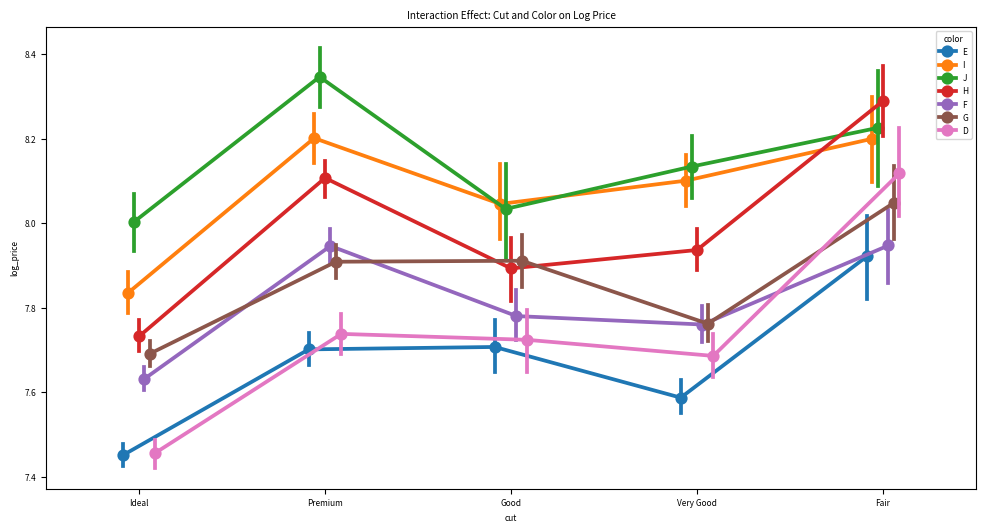

In [50]:
plt.figure(figsize=(12, 6))
sb.pointplot(data=pre_df2, x='cut', y='log_price', hue='color', dodge=True)
plt.title('Interaction Effect: Cut and Color on Log Price')
plt.show()

#### 5.2 사후검정 결과 필터링 (Top 차이만 추출)
- 차이가 가장 큰 조합이나 예상을 벗어난 결과 확인

In [51]:
# 가격 차이(diff)가 가장 큰 상위 10개 조합 확인
top_diff = hoc_df.sort_values(by='diff', ascending=False).head(10)
display(top_diff.head())

# 통계적으로 유의미하지 않은(p > 0.05) 조합만 따로 확인 (의외로 비슷한 그룹들)
not_sig = hoc_df[hoc_df['pval'] > 0.05]
not_sig.head()

A          B  mean(A)  mean(B)  diff    se      T        df  pval  \
1     Fair      Ideal    8.093    7.639 0.454 0.020 22.391  2033.506 0.000   
3     Fair  Very Good    8.093    7.799 0.294 0.021 13.818  2469.220 0.000   
0     Fair       Good    8.093    7.842 0.251 0.024 10.579  3475.310 0.000   
4     Good      Ideal    7.842    7.639 0.203 0.016 13.047  7354.842 0.000   
9  Premium  Very Good    7.950    7.799 0.151 0.013 11.749 25369.321 0.000   

   hedges  
1   0.464  
3   0.292  
0   0.269  
4   0.205  
9   0.146

A          B  mean(A)  mean(B)  diff    se     T       df  pval  hedges
6  Good  Very Good    7.842    7.799 0.044 0.017 2.589 9554.904 0.072   0.043

>1. 가격차이가 큰 조합 상위10개 확인
>
> 비일관적인 가격 패턴: 일반적인 상식(Ideal 컷이 가장 비쌈)과 달리, 그래프에서는 Fair 또는 Premium 컷의 평균 가격이 Ideal 컷보다 높게 형성되는 구간이 많습니다.
>
>상호작용의 존재: 모든 컬러 라인이 평행하지 않고 서로 교차하거나 간격이 달라집니다. 이는 특정 컷에서 컬러의 영향력이 다른 컷에서와 다르게 나타남을 의미합니다.
>
>Color 등급의 역설: 일부 구간에서는 낮은 등급의 컬러(예: J, I)가 높은 등급(예: D, E)보다 가격이 높게 나타나는 현상이 관찰됩니다. 이는 Carat(중량) 등 분석에 포함되지 않은 강력한 외생 변수가 개입되어 있을 가능성을 강력히 시사합니다.
>
> 2. 통계적으로 유의미하지 않은 조합 상위 10개만 확인
>
> **질적 차이가 가장 큰 그룹 (Top 10)**:Fair_H vs Ideal_E (diff: 0.838, hedges: 1.008) 등에서 매우 큰 차이가 나타납니다.
>
> 효과 크기(hedges)가 0.8 이상인 조합들이 다수 발견되며, 이는 통계적 유의성을 넘어 실질적으로도 매우 큰 가격 차이가 존재함을 의미합니다.
> 
> **차이가 거의 없는 그룹 (Not Sig)**:Fair_D와 Fair_E, F, G, H, I 사이의 p-value는 모두 0.05보다 큽니다 (0.805~1.000).
>
> 즉, Fair 컷 내에서는 컬러 등급이 바뀌어도 가격 차이가 통계적으로 유의미하지 않음을 알 수 있습니다.

> 단순히 품질이 좋으면 비싸다는 가설을 넘어, 복합적이 영향력을 확인하기 위함.
>
> 다이아몬드 가격은 cut하나로 결정되지 않기에 color, clarity가 cut과 결합했을 때 가격에 어떤 패턴을 만드는지를 확인하고자 하였다. 
>
> 이원 분산분석을 수행하여 cut과 color가 각각 가격에 영향을 주는지(주효과), 그리고 두 요인 결합했을 때 시너지나 상호작용 효과를 통계적으로 증명하기 위해 작성되었다.
>
> 1번 과정의 등급별 평균값을 통해 실제 시장의 직관과 데이터 수치가 일치하는지 검증하고자 함
>
> 
> 즉, 단순히 등급이 높다고 평균 가격이 높은 것은 아니다.
>
> 다이아몬드 가격은 단순히 컷이 좋거나 컬러가 좋다고 해서 비싸지는 선형적인 구조가 아님이 밝혀졌습니다. 이원분산분석에서 상호작용이 유의미하게 나타난 것처럼, 컷과 컬러의 조합에 따라 가격은 매우 복합적으로 움직입니다.

## **미션8_"가격과 가장 가까운 물리적 변수는?"**
-----------------
- 연속형 변수들 사이의 상관관계를 계산해 보자
- price와 carat, x,y,z,depth, table 중 어떤 변수가 가장 강한 관계를 보이는지 확인해 보고, 왜 그런 결과가 나왔는지 설명
- 이 과정에서 Pearson 과 Spearman 중 어떤 상관계수가 더 적절한지도 함께 고민해 보자
  
> 연속형 변수 관계를 요약할 때 어떤 계수를 쓰고, 왜 그 선택이 타당한지 설명하는 연습. 물리적 의미와 수치가 만나는 지점을 찾아라

-------------
🧠 어떻게 문제를 풀어볼까나?!

1. 연속형 변수들 사이의 상관관계 -> 상관행렬
---------------

#### 1. 상관계수

In [52]:
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

In [53]:
df8 = pre_df2[["log_price","log_carat","x", "y", "z", "depth", "table" ]]

corr_data = df8.corr()
corr_data

log_price  log_carat      x      y     z  depth  table
log_price      1.000      0.966  0.961  0.938 0.942  0.001  0.158
log_carat      0.966      1.000  0.993  0.969 0.976  0.031  0.192
x              0.961      0.993  1.000  0.975 0.975 -0.025  0.196
y              0.938      0.969  0.975  1.000 0.957 -0.029  0.184
z              0.942      0.976  0.975  0.957 1.000  0.095  0.152
depth          0.001      0.031 -0.025 -0.029 0.095  1.000 -0.296
table          0.158      0.192  0.196  0.184 0.152 -0.296  1.000

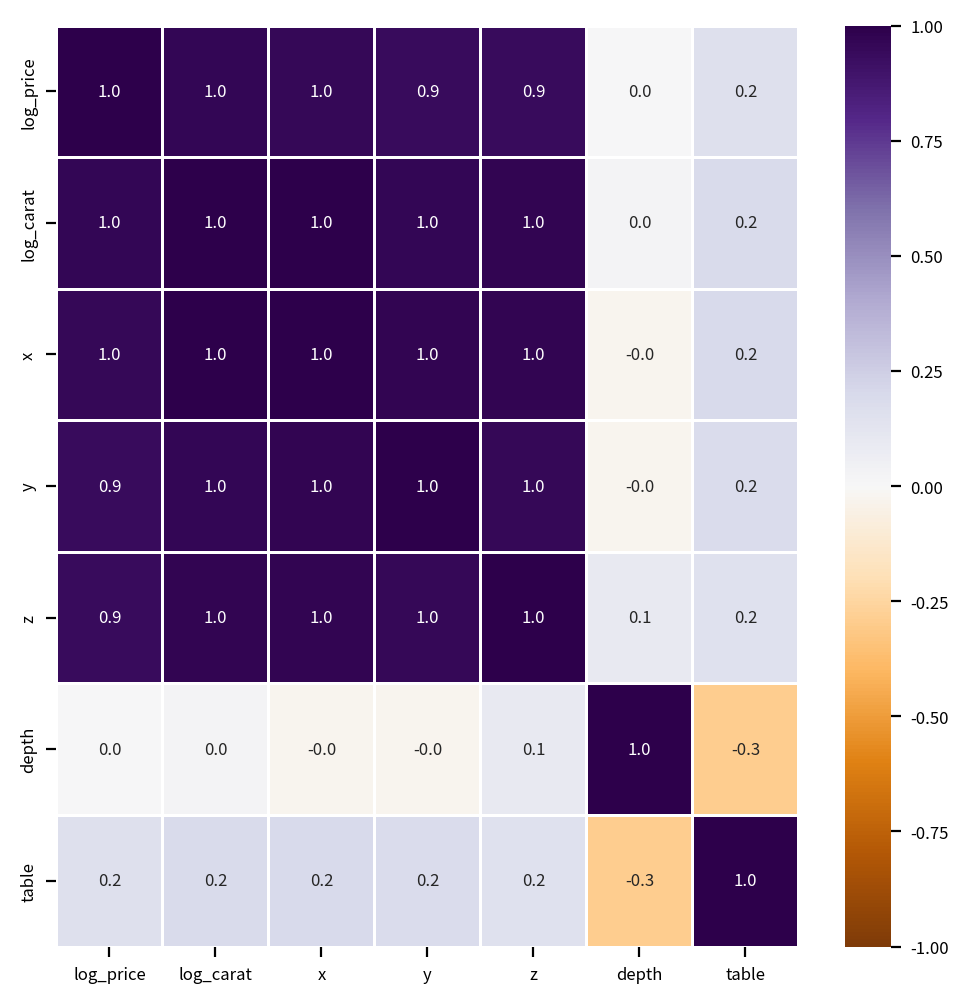

In [54]:
width_px = 1000
height_px = 1000
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_data, annot=True, fmt="0.1f",center=0,vmin=-1, vmax=1, linewidth=0.5, cmap="PuOr")

plt.tight_layout()
plt.show()
plt.close()

In [55]:
# 이상치와 왜도 검정
continuous_cols = ['log_price', 'log_carat', 'x', 'y', 'z', 'depth', 'table']
data = pre_df2[continuous_cols]

results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|Z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
}
    
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

original_skew log_skew outliers(|z|>3) log_recommended
log_price         0.115   -0.226               0           False
log_carat         0.096   -0.145               6           False
x                 0.398   -0.013              35           False
y                 2.462    0.016              27            True
z                 1.585    0.195              36            True
depth            -0.082   -2.177             685           False
table             0.797    0.160             335           False

이상치가 발견되어 스피어만 상관계수 사용


In [56]:
cols = ['log_price', 'log_carat', 'x', 'y', 'z', 'depth', 'table']
data = pre_df2[cols]

rows = []

# 모든 변수 쌍에 대해 반복
for a, b in combinations(data.columns, 2):
    x_data = data[a]
    y_data = data[b]

    # [1] 선형성 확인 (Ramsey RESET Test)
    # 선형 회귀 모델이 적합한지 판별
    X = sm.add_constant(x_data)
    model = sm.OLS(y_data, X).fit()
    
    # 데이터 포인트가 부족하거나 상수가 포함된 경우를 대비한 예외 처리
    try:
        reset = reset_ramsey(model, degree=2)
        linearity_ok = reset.pvalue > 0.05
    except:
        linearity_ok = False

    # [2] 이상치 존재 여부 (|z| > 3 기준)
    # 이전 단계에서 생성한 results_df(또는 skew_outlier_df)를 참조
    a_flag = results_df.loc[a, 'outliers(|z|>3)'] > 0
    b_flag = results_df.loc[b, 'outliers(|z|>3)'] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    # 선형적이고 이상치가 없을 때만 Pearson, 그 외에는 Spearman 사용
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x_data, y_data)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x_data, y_data)
    
    # [4] 유의성 및 강도 판단
    significant = pval <= 0.05
    abs_r = abs(corr)
    
    if abs_r >= 0.80: strength = 'Very strong'
    elif abs_r >= 0.60: strength = 'Strong'
    elif abs_r >= 0.40: strength = 'Medium'
    elif abs_r >= 0.20: strength = 'Weak'
    else: strength = 'Very weak'
    
    rows.append({
        "var_a": a, "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": round(corr, 4),
        "pval": f"{pval:.3e}",
        "significant": significant,
        "strength": strength
    })

# 결과 출력
summary_df = pd.DataFrame(rows)
summary_df

var_a      var_b  linearity  outlier_flag    chosen   corr  \
0   log_price  log_carat      False          True  spearman  0.963   
1   log_price          x      False          True  spearman  0.964   
2   log_price          y      False          True  spearman  0.963   
3   log_price          z      False          True  spearman  0.959   
4   log_price      depth      False          True  spearman  0.010   
5   log_price      table      False          True  spearman  0.172   
6   log_carat          x      False          True  spearman  0.997   
7   log_carat          y      False          True  spearman  0.996   
8   log_carat          z      False          True  spearman  0.995   
9   log_carat      depth      False          True  spearman  0.030   
10  log_carat      table      False          True  spearman  0.195   
11          x          y      False          True  spearman  0.998   
12          x          z      False          True  spearman  0.988   
13          x      depth      False          True  spearman -0.023   
14          x      table      False          True  spearman  0.202   
15          y          z      False          True  spearman  0.988   
16          y      depth      False          True  spearman -0.025   
17          y      table      False          True  spearman  0.196   
18          z      depth      False          True  spearman  0.104   
19          z      table      False          True  spearman  0.160   
20      depth      table      False          True  spearman -0.245   

          pval  significant     strength  
0    0.000e+00         True  Very strong  
1    0.000e+00         True  Very strong  
2    0.000e+00         True  Very strong  
3    0.000e+00         True  Very strong  
4    2.006e-02         True    Very weak  
5    0.000e+00         True    Very weak  
6    0.000e+00         True  Very strong  
7    0.000e+00         True  Very strong  
8    0.000e+00         True  Very strong  
9    2.530e-12         True    Very weak  
10   0.000e+00         True    Very weak  
11   0.000e+00         True  Very strong  
12   0.000e+00         True  Very strong  
13   7.001e-08         True    Very weak  
14   0.000e+00         True         Weak  
15   0.000e+00         True  Very strong  
16   4.939e-09         True    Very weak  
17   0.000e+00         True    Very weak  
18  1.802e-128         True    Very weak  
19  3.707e-307         True    Very weak  
20   0.000e+00         True         Weak

In [57]:
summary_df.head()

var_a      var_b  linearity  outlier_flag    chosen  corr       pval  \
0  log_price  log_carat      False          True  spearman 0.963  0.000e+00   
1  log_price          x      False          True  spearman 0.964  0.000e+00   
2  log_price          y      False          True  spearman 0.963  0.000e+00   
3  log_price          z      False          True  spearman 0.959  0.000e+00   
4  log_price      depth      False          True  spearman 0.010  2.006e-02   

   significant     strength  
0         True  Very strong  
1         True  Very strong  
2         True  Very strong  
3         True  Very strong  
4         True    Very weak

### **미션8_인사이트**

> price에 따른 x,y,z,carat이 0.9라는 강한 양의 상관관계를 보이며, depth-table는 -0.3으로 약한 음의 상관관계를 보인다.
> 즉, price가 비쌀수록 x,y,z,carat는 커지는 것을 의미하고, depth가 작아질수록 table는 커지는 것으로 해석할 수 있다.
>
> 각 변수에 따른 자기상관성을 제외하고도 1.0을 보이며 서로 거의 동일한 정보를 담고 있는 선형적인 관계임을 알 수 있다. 또한 depth와의 상관관계의 대부분은  상관계수가 0을 나타내면 비선형적 관계로 무관하다는 사실을 파악할 수 있다.
>
> 해당 과정에서 Pearson과 Spearman 중 어떤 상관계수가 더 적절한지를 판단해보자면 Spearman이 데이터가 비선형 또는 둘 중 하나라도 이상치가 많을 경우 사용하며 순위(rank) 기반으로 계산하므로 이상치에 덜 민감하기에 해당 상관분석이 더 적절하다고 판단하였다.

## **미션9_"상관관계는 곧 원인일까?"**
----------
- 상관분석 결과를 바탕으로 다음 질문에 답해 보자.
  - 상관이 높다는 것은 무엇을 의미하는가?
  - 이 결과를 그대로 "원인"이라고 말해도 될까?
- 분석 결과의 한계를 스스로 짚어보는 것이 이번 미션의 핵심이다.
> "상관이 높다=원인이다"라는 착각을 피하도록, 데이터가 말해 주지 않는 부분과 한계를 스스로 보게 합니다.

### **미션9_인사이트**
> 미션8의 결과를 통해 연속형 변수들이 가지는 상관관계에 대해서 수치적으로 확인해본 결과, price와 x,y,z,carat
>
> 상관계수 0.9는 두 변수가 비례한다는 뜻으로 carat나 x,y,z가 커질 때 price도 거의 일정한 비율로 비싸진다는 것이다. 
>
> 상관분석 결과에 따라 원인이라고 확신할 수는 없다. 상관분석을 통해 관련이 있다만 확인할 수 있으며 정확한 원인을 확인하고자 한다면 인과관계를 확인해봐야 할 것이다.

## **미션10_"가격을 설명하는 회귀모형을 만들어보자"**
---------------------
- log(price)를 종속변수로 하는 다중선형회귀모형
  - 변수 선정시 어떤 기준으로 선택을 하였는지 스스로 점검
- 회귀계수 하나하나가 가격 구조를 어떻게 설명해 주는지 서술
> 변수 선택과 모델 설계는 "설명하고 싶은 세계"에 맞춰보는 연습. 계수는 단순 숫자가 아닌 가격 구조의 언어로 바꾸는 것이 목표

In [58]:
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [63]:
drop_df2 = pre_df2.copy()
# drop_df2['log_price'] = np.log1p(drop_df2['price'])
# drop_df2.drop('price', axis=1, inplace=True)
# drop_df2['log_carat'] = np.log1p(drop_df2['carat'])
# drop_df2.drop('carat', axis=1, inplace=True)
drop_df2.head()

log_price  price  log_carat  carat  map_carat      cut  map_cut color  \
0      5.787    326     -1.470  0.230          1    Ideal        1     E   
1      5.787    326     -1.561  0.210          1  Premium        2     E   
2      5.790    327     -1.470  0.230          1     Good        4     E   
3      5.811    334     -1.238  0.290          1  Premium        2     I   
4      5.814    335     -1.171  0.310          1     Good        4     J   

   map_color clarity  map_clarity     x     y     z  depth  table  
0          2     SI2            7 3.950 3.980 2.430 61.500 55.000  
1          2     SI1            6 3.890 3.840 2.310 59.800 61.000  
2          2     VS1            4 4.050 4.070 2.310 56.900 65.000  
3          6     VS2            5 4.200 4.230 2.630 62.400 58.000  
4          7     SI2            7 4.340 4.350 2.750 63.300 58.000

In [65]:
# 1. 매핑 딕셔너리 생성 (역순으로 숫자를 부여하여 높은 등급이 큰 값을 갖게 함)
map_clarity = {v: i for i, v in enumerate(reversed(clarity_order))}
map_color = {v: i for i, v in enumerate(reversed(color_order))}
map_cut = {v: i for i, v in enumerate(reversed(cut_order))}

# 2. 데이터프레임에 매핑 적용
drop_df3 = drop_df2.copy()
# drop_df3['map_clarity'] = drop_df2['clarity'].map(map_clarity)
# drop_df3.drop('clarity', axis=1, inplace=True)
# drop_df3['map_color'] = drop_df2['color'].map(map_color)
# drop_df3.drop('color', axis=1, inplace=True)



# drop_df3['map_cut'] = drop_df2['cut'].map(map_cut)
# drop_df3.drop('cut', axis=1, inplace=True)
drop_df3.head()


log_price  price  log_carat  carat  map_carat      cut  map_cut color  \
0      5.787    326     -1.470  0.230          1    Ideal        1     E   
1      5.787    326     -1.561  0.210          1  Premium        2     E   
2      5.790    327     -1.470  0.230          1     Good        4     E   
3      5.811    334     -1.238  0.290          1  Premium        2     I   
4      5.814    335     -1.171  0.310          1     Good        4     J   

   map_color clarity  map_clarity     x     y     z  depth  table  
0          2     SI2            7 3.950 3.980 2.430 61.500 55.000  
1          2     SI1            6 3.890 3.840 2.310 59.800 61.000  
2          2     VS1            4 4.050 4.070 2.310 56.900 65.000  
3          6     VS2            5 4.200 4.230 2.630 62.400 58.000  
4          7     SI2            7 4.340 4.350 2.750 63.300 58.000

### 1. vif가 10 미만이 될때까지의 분석

In [66]:
df1= [ 'log_carat', 'x', 'y', 'z', 'depth', 'table']
yname = 'log_price'

x = df1.drop(yname, axis=1)
y = df1[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

AttributeError: 'list' object has no attribute 'drop'

### 2 분석결과표를 위한 함수 정의

In [ ]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
    # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "//*" if p < 0.001 else
            "/*" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,                         # 종속변수 이름
            "독립변수": name,                          # 독립변수 이름
            "B": v[1].strip(),                        # 비표준화 회귀계수(B)
            "표준오차": v[2].strip(),                 # 계수 표준오차
            "Beta": float(fit.params[name]) * (data[name].std(ddof=1) /
        data[yname].std(ddof=1)),  # 표준화 회귀계수(β)
            "t": "%s%s" % (v[3].strip(), stars(p)), # t-통계량(+별표)
            "p-value": p,                             # 계수 유의확률
            "공차": 1 / vif,                          # 공차(Tolerance = 1/VIF)
            "vif": vif,                               # 분산팽창계수
        })
        
    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = f"𝑅({result_dict['R-squared']}),𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"

    # 모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl %(
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s % (row['독립변수'],
                row['B'],
                "<=" if float(row['p-value']) < 0.05 else '>',
                row['종속변수'],
                '유의미한' if float(row['p-value']) < 0.05 else '유의하지 않은'))
        
    return rdf, result_report, model_report, variable_reports




### 2-1. 분석 결과

In [ ]:
rdf, r, m, v = ols_report(tbl1, df1)
display(rdf)
print(m)

종속변수         독립변수       B   표준오차      Beta           t  p-value  \
0  log_price            x  0.8036  0.008  0.888900   95.151//*      0.0   
1  log_price            y  0.0278  0.003  0.031281    8.180//*      0.0   
2  log_price            z  0.0417  0.006  0.028993    7.080//*      0.0   
3  log_price        depth  0.0324  0.001  0.045803   38.920//*      0.0   
4  log_price        table  0.0045  0.000  0.009871    9.271//*      0.0   
5  log_price    log_carat  0.5054  0.034  0.122034   14.837//*      0.0   
6  log_price  map_clarity  0.1155  0.001  0.187648  200.912//*      0.0   
7  log_price    map_color  0.0848  0.001  0.142196  159.650//*      0.0   
8  log_price      map_cut  0.0233  0.001  0.025695   24.996//*      0.0   

         공차          vif  
0  0.000443  2258.752516  
1  0.001880   531.857821  
2  0.001722   580.744285  
3  0.001611   620.543404  
4  0.001613   619.832058  
5  0.002558   390.874948  
6  0.187844     5.323564  
7  0.179400     5.574142  
8  0.103462     9.665341

log_price에 대하여 x,y,z,depth,table,log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(9,53930) = 1.501e+05, p <= 0.05).



 - vif값이 10이상 제거, But 한꺼번에 제거하는 것이 아닌 하나씩 제거해야 함
> vif값이 제일 큰 x에 대해서 우선적으로 삭제를 시도

In [ ]:
df2 = df1.drop('x', axis=1)
df1['log_price'] = origin['log_price']
yname = 'log_price'

x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df2)
display(rdf)
print(m)

종속변수         독립변수        B   표준오차      Beta           t  p-value  \
0  log_price            y   0.1195  0.004  0.134635   33.981//*      0.0   
1  log_price            z   0.2367  0.006  0.164731   39.708//*      0.0   
2  log_price        depth  -0.0047  0.001 -0.006603   -5.875//*      0.0   
3  log_price        table   0.0025  0.001  0.005521    4.802//*      0.0   
4  log_price    log_carat   3.2042  0.020  0.773653  157.157//*      0.0   
5  log_price  map_clarity   0.1108  0.001  0.179916  178.931//*      0.0   
6  log_price    map_color   0.0867  0.001  0.145435  151.208//*      0.0   
7  log_price      map_cut   0.0265  0.001  0.029170   26.275//*      0.0   

         공차         vif  
0  0.002289  436.858769  
1  0.001853  539.672050  
2  0.001643  608.755471  
3  0.002171  460.538672  
4  0.005887  169.851516  
5  0.187861    5.323090  
6  0.180325    5.545548  
7  0.117741    8.493207

log_price에 대하여 y,z,depth,table,log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,53931) = 1.436e+05, p <= 0.05).


In [ ]:
df3 = df2.drop('depth', axis=1)
yname = 'log_price'

x = df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl3 = fit.summary()

rdf, r, m, v = ols_report(tbl3, df3)
display(rdf)
print(m)

종속변수         독립변수       B   표준오차      Beta           t  p-value  \
0  log_price            y  0.1255  0.003  0.141367   37.260//*      0.0   
1  log_price            z  0.2268  0.006  0.157794   39.664//*      0.0   
2  log_price        table  0.0038  0.000  0.008378    8.040//*      0.0   
3  log_price    log_carat  3.2043  0.020  0.773676  157.113//*      0.0   
4  log_price  map_clarity  0.1110  0.001  0.180249  179.490//*      0.0   
5  log_price    map_color  0.0869  0.001  0.145702  151.608//*      0.0   
6  log_price      map_cut  0.0287  0.001  0.031565   30.558//*      0.0   

         공차         vif  
0  0.002292  436.393237  
1  0.002503  399.524274  
2  0.005674  176.248222  
3  0.007357  135.930530  
4  0.189414    5.279450  
5  0.180527    5.539345  
6  0.123538    8.094693

log_price에 대하여 y,z,table,log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(7,53932) = 1.640e+05, p <= 0.05).


In [ ]:
df4 = df3.drop('y', axis=1)
yname = 'log_price'

x = df4.drop(yname, axis=1)
y = df4[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl4 = fit.summary()

rdf, r, m, v = ols_report(tbl4, df4)
display(rdf)
print(m)

종속변수         독립변수       B   표준오차      Beta           t  p-value  \
0  log_price            z  0.2675  0.006  0.186176   47.079//*      0.0   
1  log_price        table  0.0050  0.000  0.011080   10.525//*      0.0   
2  log_price    log_carat  3.6594  0.017  0.883551  221.211//*      0.0   
3  log_price  map_clarity  0.1110  0.001  0.180302  177.278//*      0.0   
4  log_price    map_color  0.0875  0.001  0.146850  150.951//*      0.0   
5  log_price      map_cut  0.0324  0.001  0.035651   34.271//*      0.0   

         공차         vif  
0  0.002781  359.636136  
1  0.008121  123.140733  
2  0.011265   88.770880  
3  0.189560    5.275388  
4  0.180896    5.528051  
5  0.129539    7.719693

log_price에 대하여 z,table,log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,53933) = 1.863e+05, p <= 0.05).


In [ ]:
df5 = df4.drop('z', axis=1)
yname = 'log_price'

x = df5.drop(yname, axis=1)
y = df5[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl5 = fit.summary()

rdf, r, m, v = ols_report(tbl5, df5)
display(rdf)
print(m)

종속변수         독립변수       B   표준오차      Beta           t  p-value  \
0  log_price        table  0.0011  0.000  0.002411      2.280*    0.023   
1  log_price    log_carat  4.4104  0.004  1.064890  987.461//*    0.000   
2  log_price  map_clarity  0.1100  0.001  0.178604  172.217//*    0.000   
3  log_price    map_color  0.0880  0.001  0.147588  148.707//*    0.000   
4  log_price      map_cut  0.0278  0.001  0.030611   28.993//*    0.000   

         공차        vif  
0  0.035165  28.437078  
1  0.124381   8.039807  
2  0.189815   5.268274  
3  0.181532   5.508681  
4  0.133326   7.500415

log_price에 대하여 table,log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,53934) = 2.144e+05, p <= 0.05).


In [ ]:
df6 = df5.drop('table', axis=1)
yname = 'log_price'

x = df6.drop(yname, axis=1)
y = df6[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl6 = fit.summary()

rdf, r, m, v = ols_report(tbl6, df6)
display(rdf)
print(m)

종속변수         독립변수       B   표준오차      Beta           t  p-value  \
0  log_price    log_carat  4.4116  0.004  1.065180  994.626//*      0.0   
1  log_price  map_clarity  0.1099  0.001  0.178512  172.252//*      0.0   
2  log_price    map_color  0.0880  0.001  0.147624  148.755//*      0.0   
3  log_price      map_cut  0.0269  0.001  0.029624   30.760//*      0.0   

         공차       vif  
0  0.289369  3.455790  
1  0.256432  3.899663  
2  0.267618  3.736676  
3  0.155951  6.412271

log_price에 대하여 log_carat,map_clarity,map_color,map_cut로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,53935) = 2.679e+05, p <= 0.05).


### 4. 잔차 검정
#### 1. RESET 테스트 통계량 확인

In [ ]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 49680.0125
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


#### 2. Q-Q plot

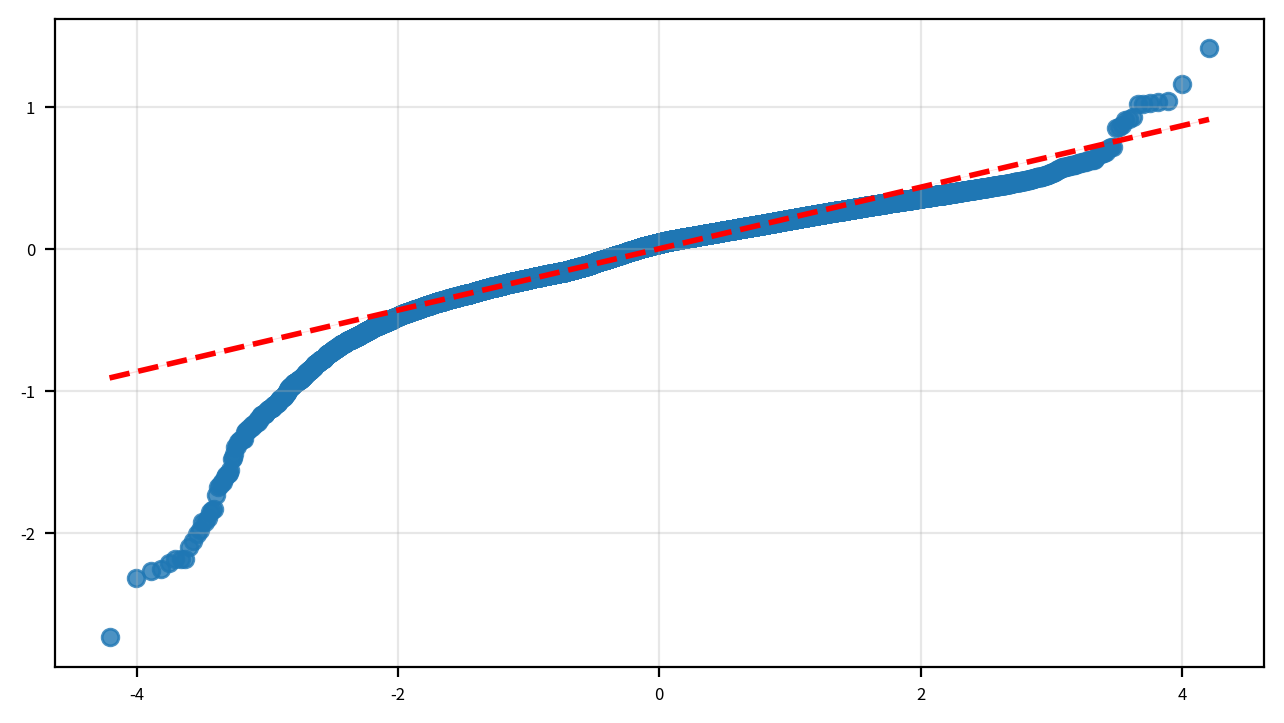

In [ ]:
(x, y), _ = probplot(fit.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
    "color": "red",
    "linestyle": "--",   
    "linewidth": 2
            })

ax.grid(True, alpha=0.3)   

plt.tight_layout()      
plt.show()              
plt.close()             


#### 3. 잔차의 시각화

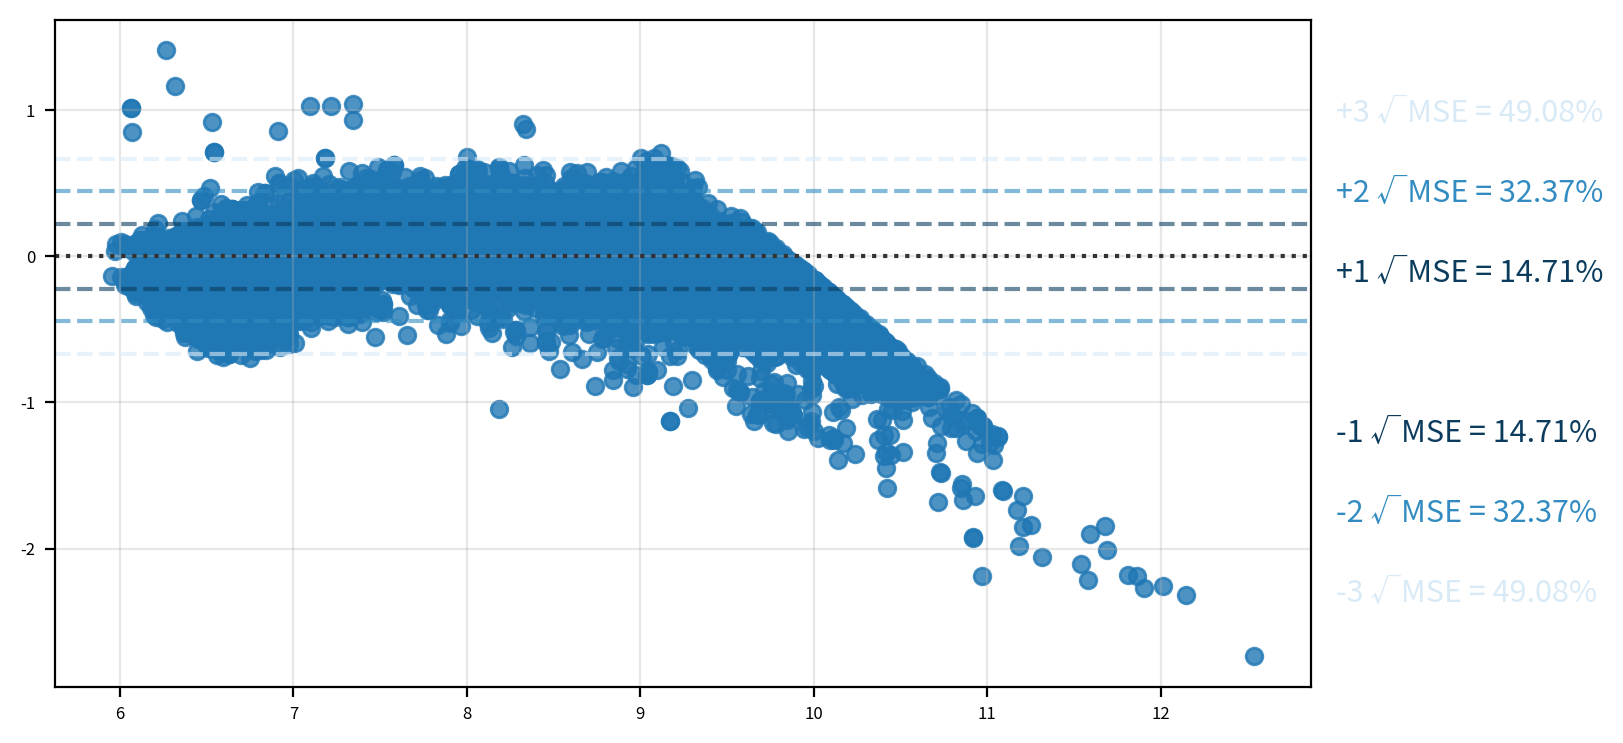

In [ ]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid   

# 잔차
r1 = r[ (r >-mse_sq) & (r < mse_sq)].count() / r.count() * 100
r2 = r[ (r >-2*mse_sq) & (r < 2*mse_sq)].count() / r.count() * 100
r3 = r[ (r >-3*mse_sq) & (r < 3*mse_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px  = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)

# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1

    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y= y_pos,  color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos,  color=c, linestyle="--", alpha=0.6)

    # 텍스트는 축 좌표계 사용(그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()


### 5. 잔차의 정규성 검정

In [ ]:
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist='norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print("정규성 가정 위배 가능성이 있음 (5% 유의수준)" if violated else "정규성 가정 위배 근거 없음 (5% 유의수준)")


Anderson-Darling statistic: 361.6778, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


### 6. 잔차의 등분산성 검정

In [ ]:
# Breusch-pegan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 912.402, p-value = 0.000
이분산성 존재(등분산 아님)


### 7. 잔차의 독립성

In [ ]:
dw = durbin_watson(fit.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)


Durbin–Watson: 1.011
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)


## **미션11_"이 회귀모형은 믿을 만할까?"**
--------------------
- 회귀분석 결과를 그대로 받아들이기 전에, 가정이 얼마나 잘 지켜졌는지 확인
- 잔차 그림과 진단 지표를 통해 어떤 가정이 잘 지켜졌는지, 어떤 부분이 아쉬운지를 정리
- 그리고 이 모형을 더 개선하려면 무엇을 해볼 수 있을지도 함께 제안
> 성능만 보는 것이 아니라, 회귀 가정과 진단을 통해 "이 모델을 어디까지 믿을 수 있는가"를 점검하고 개선 아이디어를 제시

### **미션11_인사이트**
> 회귀분석의 주요 가정 대부분의 지표에서 위배되고 있음. 해당 모델로는 신뢰할 수 있는 결과를 얻기 어렵다

## **미션12_"같은 carat, 왜 가격이 다를까?"**
-----------
- 가상의 사례를 만들어, 통계 분석과 회귀 결과를 활용해 비전공자에게 설명하듯 서술
- 이야기와 설득력을 평가